In [24]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# opensoundscape transfer learning tools
# from opensoundscape.ml.shallow_classifier import MLPClassifier, quick_fit, fit_classifier_on_embeddings

## Load Data

In [25]:
# Read dataset CSV
df = pd.read_csv("../../Dataset/CSVs/Datasets/Dataset.csv")

In [26]:
# Dont take Background or Cargo as classes
# df = df[~df['Class'].isin(['Background', 'Cargo'])]
# Make Cargo, Motor_boat and Ferry_FastFerry as Background
df.loc[df['Class'].isin(['Cargo', 'Motor_boat', 'Ferry_FastFerry', 'Human_diver']), 'Class'] = 'Background'

In [27]:
# dont take origin Neus Marine Mammals whose Class is KillerWhale
df = df[~((df['Origin'] == 'Neus Marine Mammals') & (df['Class'] == 'KillerWhale'))]
# From KillerWhale take 1000 longest files (Duration)
df_killerwhale = df[df['Class'] == 'KillerWhale'].sort_values(by='Duration', ascending=False).head(1300)
df = df[~(df['Class'] == 'KillerWhale')]
df = pd.concat([df, df_killerwhale])

In [28]:
# take Origin WOPAM Day from df
df_wopam_day = df[df['Origin'] == 'SEANIMALMOVE WOPAM Day']
df = df[~(df['Origin'] == 'SEANIMALMOVE WOPAM Day')]

In [29]:
# Concat all dataframes
df_train = df[df["Subset"] == "train"]
df_val = df[df["Subset"] == "val"]
df_test = df[df["Subset"] == "test"]

# reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [30]:
# All classes that are not Background, make them Whistle
df_train.loc[~df_train['Class'].isin(['Background']), 'Class'] = 'Whistle'
df_val.loc[~df_val['Class'].isin(['Background']), 'Class'] = 'Whistle'
df_test.loc[~df_test['Class'].isin(['Background']), 'Class'] = 'Whistle'
df.loc[~df['Class'].isin(['Background']), 'Class'] = 'Whistle'
df_wopam_day.loc[~df_wopam_day['Class'].isin(['Background']), 'Class'] = 'Whistle'

In [31]:
df_background = df_train[df_train['Class'].isin(['Background'])]
df_background = df_background.reset_index(drop=True)

In [32]:
# from SEANIMALMOVE origin, take only 1000 samples
df_seanimalmove = df_train[df_train['Origin'] == 'SEANIMALMOVE']
# len(df_seanimalmove)
df_seanimalmove = df_seanimalmove.sample(1000)
df_train = df_train[~(df_train['Origin'] == 'SEANIMALMOVE')]
df_train = pd.concat([df_train, df_seanimalmove])

In [33]:
# For those classes with less than 1000 samples, upsample until they have 1000 samples
def up_sampling(dataframe, num_samples=100):

    # Classes and their files
    classes = dataframe['Class'].unique()

    for class_df in classes:
        # Get the number of samples in the class
        num_samples_class = len(dataframe[dataframe['Class'] == class_df])
        
        # If the number of samples is less than 1000
        if num_samples_class < num_samples:
            # Calculate the number of samples to add
            num_samples_to_add = num_samples - num_samples_class
            
            # Get the files to add
            files_to_add = dataframe[dataframe['Class'] == class_df].sample(num_samples_to_add, replace=True)
            
            # Concatenate the files to the dataframe
            dataframe = pd.concat([dataframe, files_to_add])
    
    return dataframe

In [34]:
# If SegmentPath contains Human_diver extract in a df
df_human_diver = df_train[df_train['FilePath'].str.contains('Human_diver')]
df_train = df_train[~df_train['FilePath'].str.contains('Human_diver')]
# upsample df_human_diver
df_human_diver_upsampled = up_sampling(df_human_diver, num_samples=500)
df_train = pd.concat([df_train, df_human_diver])

df_human_diver_val = df_val[df_val['FilePath'].str.contains('Human_diver')]
df_val = df_val[~df_val['FilePath'].str.contains('Human_diver')]
# upsample df_human_diver_val
df_human_diver_val = up_sampling(df_human_diver_val, num_samples=100)
df_val = pd.concat([df_val, df_human_diver_val])

In [35]:
df_train_upsampled = up_sampling(df_train, num_samples=4500)
df_val_upsampled = up_sampling(df_val, num_samples=1500)
df_train = pd.concat([df_train, df_human_diver])

In [36]:
# concat human diver
df_train_upsampled = pd.concat([df_train_upsampled, df_human_diver_upsampled])
df_val_upsampled = pd.concat([df_val_upsampled, df_human_diver_val])

In [37]:
df_upsampled = pd.concat([df_train_upsampled, df_val_upsampled, df_test])

In [38]:
df_original = df
df = df_upsampled

## Splitting the data

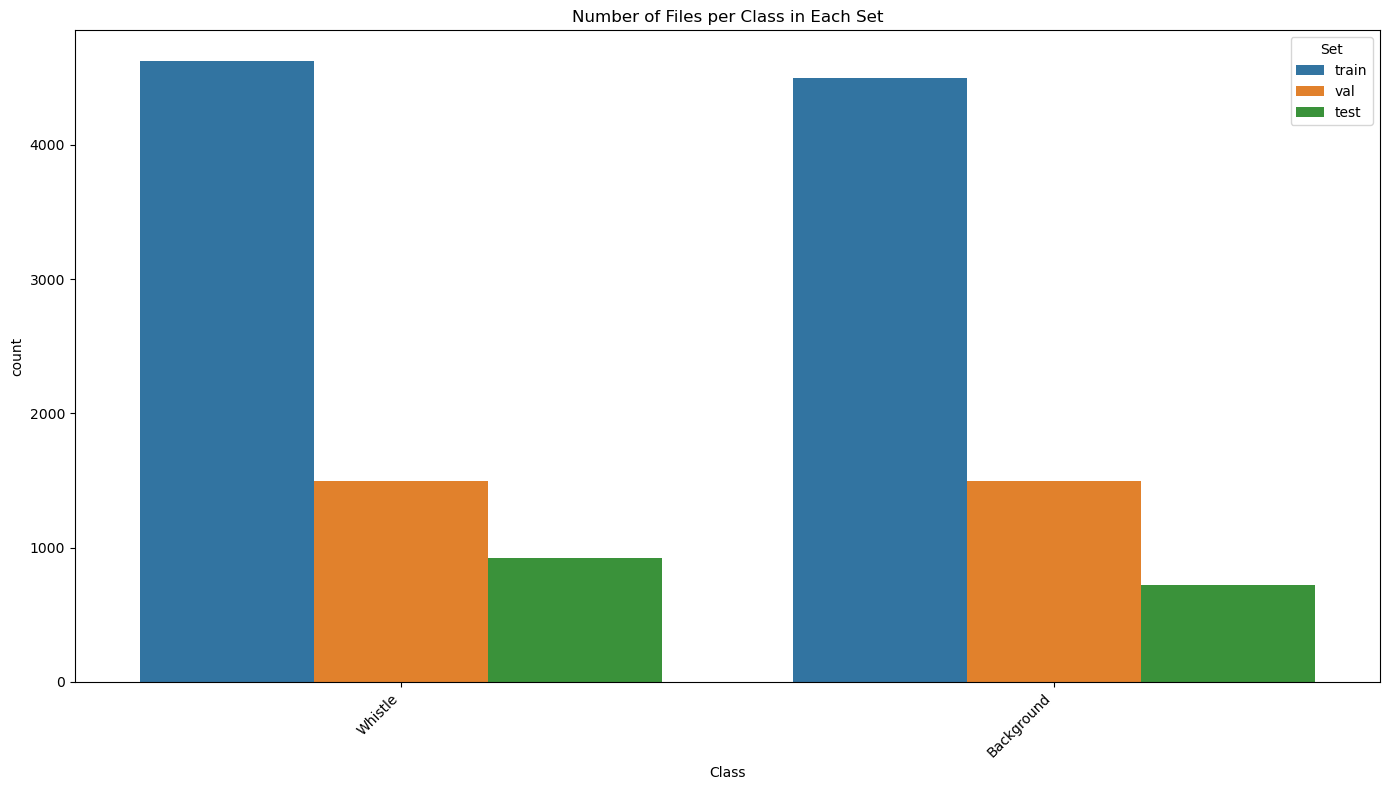

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create train-test split (80-20)
train_df = df[df["Subset"] == "train"]
val_df = df[df["Subset"] == "val"]
test_df = df[df["Subset"] == "test"]

# Plot count per class, each subset is a bar for each class (train, val and test)
class_counts = df['Class'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(14, 8))
sns.countplot(data=df, x='Class', hue='Subset', order=class_counts.index)
plt.title('Number of Files per Class in Each Set')
plt.xticks(rotation=45, ha='right', fontsize=10)  # Adjust fontsize and alignment
plt.legend(title='Set')
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()

## OpenSoundScape Dataset

In [40]:
def load_labels_from_df(df):
    # Listar las clases únicas
    class_labels = sorted(df['Class'].unique())

    # Crear una nueva lista para los resultados
    data = []

    # Iterar sobre las filas del dataframe original
    for _, row in df.iterrows():
        # Extraer la ruta de archivo y la duración
        file_path = row['SegmentPath']
        duration = round(row['Duration'], 2) - 0.03
        start_time = 0
        end_time = start_time + duration
        
        # Crear una fila con la información de tiempo y clases
        row_data = {
            'file': file_path,
            'start_time': start_time,
            'end_time': end_time
        }
        
        # Marcar las clases correspondientes en cada intervalo
        for label in class_labels:
            # Si el intervalo pertenece a esta clase, marcamos True, sino False
            if row['Class'] == label:
                row_data[label] = True
            else:
                row_data[label] = False
        
        # Agregar la fila generada al conjunto de datos
        data.append(row_data)

    # Convertir la lista de filas a un DataFrame
    df_labels = pd.DataFrame(data)

    # Reorganizar las columnas para tener file, start_time, end_time seguidos de las clases
    df_labels = df_labels[['file', 'start_time', 'end_time'] + list(class_labels)]

    # Establecer el índice como 'file', 'start_time', y 'end_time'
    df_labels.set_index(['file', 'start_time', 'end_time'], inplace=True)

    return df_labels

train_labels = load_labels_from_df(train_df)
val_labels = load_labels_from_df(val_df)
test_labels = load_labels_from_df(test_df)

In [41]:
train_labels

,,,Background,Whistle
file,start_time,end_time,,
../../Dataset/Audios/Watkins Marine Mammals/Segmented/Grampus_Risso'sDolphin/5903001Q_0_1.07.wav,0,1.04,False,True
../../Dataset/Audios/Watkins Marine Mammals/Segmented/Long_FinnedPilotWhale/7501000L_0_1.88.wav,0,1.85,False,True
../../Dataset/Audios/Watkins Marine Mammals/Segmented/CommonDolphin/8700300M_0_1.42.wav,0,1.39,False,True
../../Dataset/Audios/Watkins Marine Mammals/Segmented/CommonDolphin/57026079_0_2.58.wav,0,2.55,False,True
../../Dataset/Audios/Watkins Marine Mammals/Segmented/CommonDolphin/57026007_0_1.16.wav,0,1.13,False,True
...,...,...,...,...
../../Dataset/Audios/SEANIMALMOVE/SegmentedAudiosMultiLabel3/channelA_2024-05-28_03-02-24_21_24.wav,0,2.97,True,False
../../Dataset/Audios/SEANIMALMOVE/SegmentedAudiosMultiLabel3/channelA_2024-05-28_12-53-24_36_39.wav,0,2.97,True,False
../../Dataset/Audios/SEANIMALMOVE/SegmentedAudiosMultiLabel3/channelA_2024-05-28_12-40-24_3_6.wav,0,2.97,True,False


## Train Model

In [42]:
import bioacoustics_model_zoo as bmz

In [43]:
# Load a pretrained model
birdnet = bmz.BirdNET()  # or bmz.load('Perch')

File BirdNET_GLOBAL_6K_V2.4_Labels_af.txt already exists; skipping download.
downloading model from URL...
File BirdNET_GLOBAL_6K_V2.4_Model_FP16.tflite already exists; skipping download.


/home/gruncrow/anaconda3/envs/bmz/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:621: UserWarning: 
                    This architecture is not listed in opensoundscape.ml.cnn_architectures.ARCH_DICT.
                    It will not be available for loading after saving the model with .save() (unless using pickle=True). 
                    To make it re-loadable, define a function that generates the architecture from arguments: (n_classes, n_channels) 
                    then use opensoundscape.ml.cnn_architectures.register_architecture() to register the generating function.

                    The function can also set the returned object's .constructor_name to the registered string key in ARCH_DICT
                    to avoid this warning and ensure it is reloaded correctly by opensoundscape.ml.load_model().

                    See opensoundscape.ml.cnn_architectures module for examples of constructor functions
                    
  warnings.warn(
/home/gruncrow/anacond

In [44]:
# Embed the training labels
emb_train = birdnet.embed(train_labels, return_dfs=False, batch_size=16, num_workers=0)

  0%|          | 0/571 [00:00<?, ?it/s]

/home/gruncrow/anaconda3/envs/bmz/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 0.31997916666666665 sec instead of 0.32 sec
  warnings.warn(error_msg)
/home/gruncrow/anaconda3/envs/bmz/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 0.31997916666666665 sec instead of 0.32 sec
  warnings.warn(error_msg)
/home/gruncrow/anaconda3/envs/bmz/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 2.6099791666666667 sec instead of 2.61 sec
  warnings.warn(error_msg)
/home/gruncrow/anaconda3/envs/bmz/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 0.6899791666666667 sec instead of 0.69 sec
  warnings.warn(error_msg)
/home/gruncrow/anaconda3/envs/bmz/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserW

In [45]:
emb_val = birdnet.embed(val_labels, return_dfs=False, batch_size=16, num_workers=0)

  0%|          | 0/188 [00:00<?, ?it/s]

/home/gruncrow/anaconda3/envs/bmz/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 1.3899791666666668 sec instead of 1.39 sec
  warnings.warn(error_msg)
/home/gruncrow/anaconda3/envs/bmz/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 2.7799791666666667 sec instead of 2.78 sec
  warnings.warn(error_msg)
/home/gruncrow/anaconda3/envs/bmz/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 0.7099791666666667 sec instead of 0.71 sec
  warnings.warn(error_msg)
/home/gruncrow/anaconda3/envs/bmz/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 2.2799583333333335 sec instead of 2.28 sec
  warnings.warn(error_msg)
/home/gruncrow/anaconda3/envs/bmz/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWar

### Change classification head

In [46]:
birdnet.change_classes(sorted(df['Class'].unique()))

### BirdNET - Training

In [47]:
# fit the classification head with embeddings and labels
birdnet.network.fit(emb_train, train_labels.values, emb_val, val_labels.values)

Epoch 100/1000, Loss: 0.06746448576450348, Val Loss: 0.08099351823329926
val AU ROC: 0.999
val MAP: 0.999
Epoch 200/1000, Loss: 0.03469046205282211, Val Loss: 0.04472766071557999
val AU ROC: 1.000
val MAP: 1.000
Epoch 300/1000, Loss: 0.022725414484739304, Val Loss: 0.03194303438067436
val AU ROC: 1.000
val MAP: 1.000
Epoch 400/1000, Loss: 0.016566822305321693, Val Loss: 0.025493713095784187
val AU ROC: 1.000
val MAP: 1.000
Epoch 500/1000, Loss: 0.012846194207668304, Val Loss: 0.021633414551615715
val AU ROC: 1.000
val MAP: 1.000
Epoch 600/1000, Loss: 0.010368266142904758, Val Loss: 0.01906968653202057
val AU ROC: 1.000
val MAP: 1.000
Epoch 700/1000, Loss: 0.00860593281686306, Val Loss: 0.017240237444639206
val AU ROC: 1.000
val MAP: 1.000
Epoch 800/1000, Loss: 0.007291929796338081, Val Loss: 0.01586274243891239
val AU ROC: 1.000
val MAP: 1.000
Epoch 900/1000, Loss: 0.006276763044297695, Val Loss: 0.014780948869884014
val AU ROC: 1.000
val MAP: 1.000
Epoch 1000/1000, Loss: 0.00547052593

In [49]:
# make predictions by passing the embeddings through the classifier
import torch
emb_test = birdnet.embed(test_labels, return_dfs=False, batch_size=16, num_workers=0)
preds = birdnet.network(torch.tensor(emb_test).float()).detach().numpy()

  0%|          | 0/104 [00:00<?, ?it/s]

/home/gruncrow/anaconda3/envs/bmz/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 1.4699791666666666 sec instead of 1.47 sec
  warnings.warn(error_msg)
/home/gruncrow/anaconda3/envs/bmz/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 1.2599791666666667 sec instead of 1.26 sec
  warnings.warn(error_msg)
/home/gruncrow/anaconda3/envs/bmz/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 2.7599791666666667 sec instead of 2.76 sec
  warnings.warn(error_msg)
/home/gruncrow/anaconda3/envs/bmz/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 2.9699375 sec instead of 2.97 sec
  warnings.warn(error_msg)
/home/gruncrow/anaconda3/envs/bmz/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWarning: Aud

array([0.99999702, 1.        ])

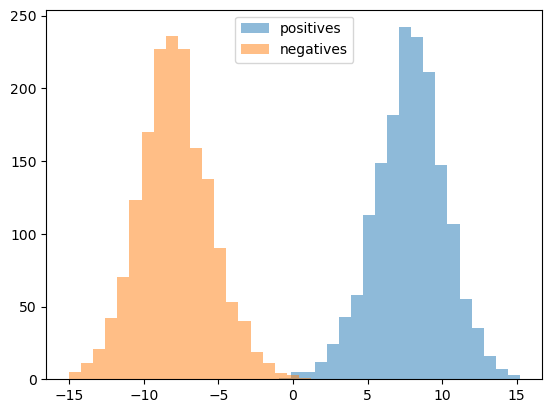

In [50]:
from sklearn.metrics import roc_auc_score

# plot histogram of scores for positive and negative clips
plt.hist(preds[test_labels==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[test_labels==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score(test_labels.values,preds,average=None)

              precision    recall  f1-score   support

  Background       1.00      1.00      1.00       725
     Whistle       1.00      1.00      1.00       925

    accuracy                           1.00      1650
   macro avg       1.00      1.00      1.00      1650
weighted avg       1.00      1.00      1.00      1650



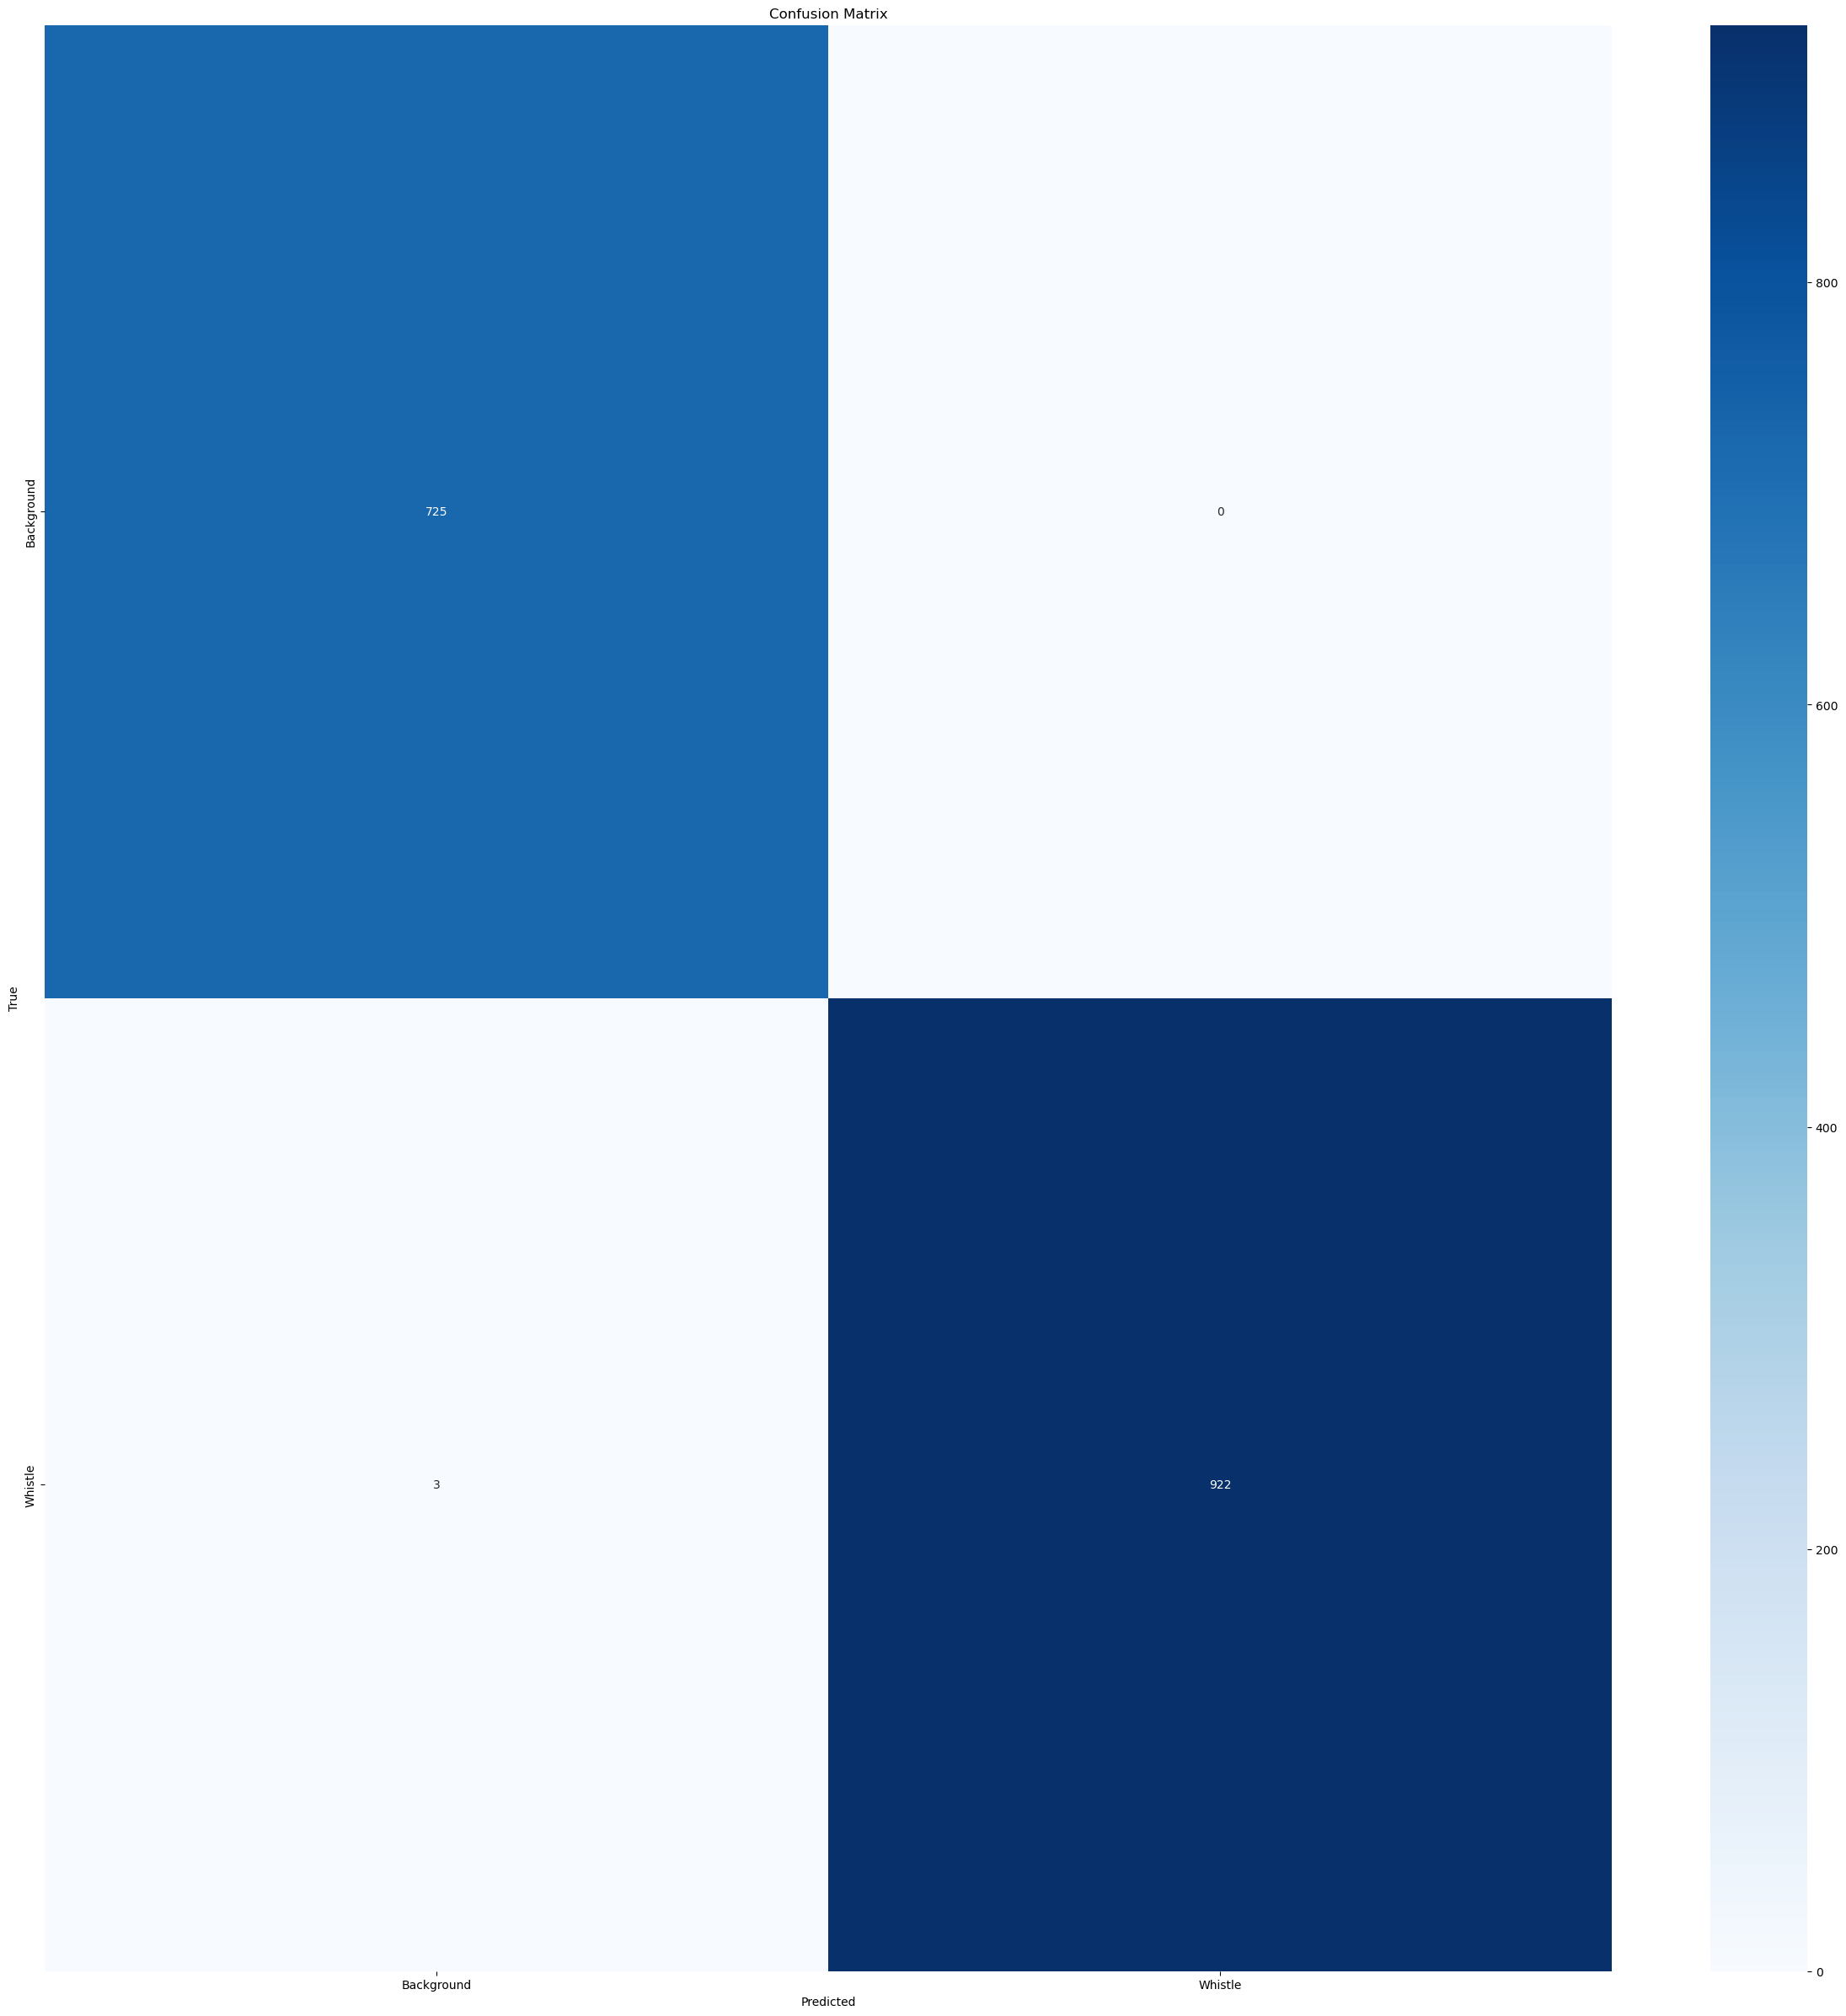

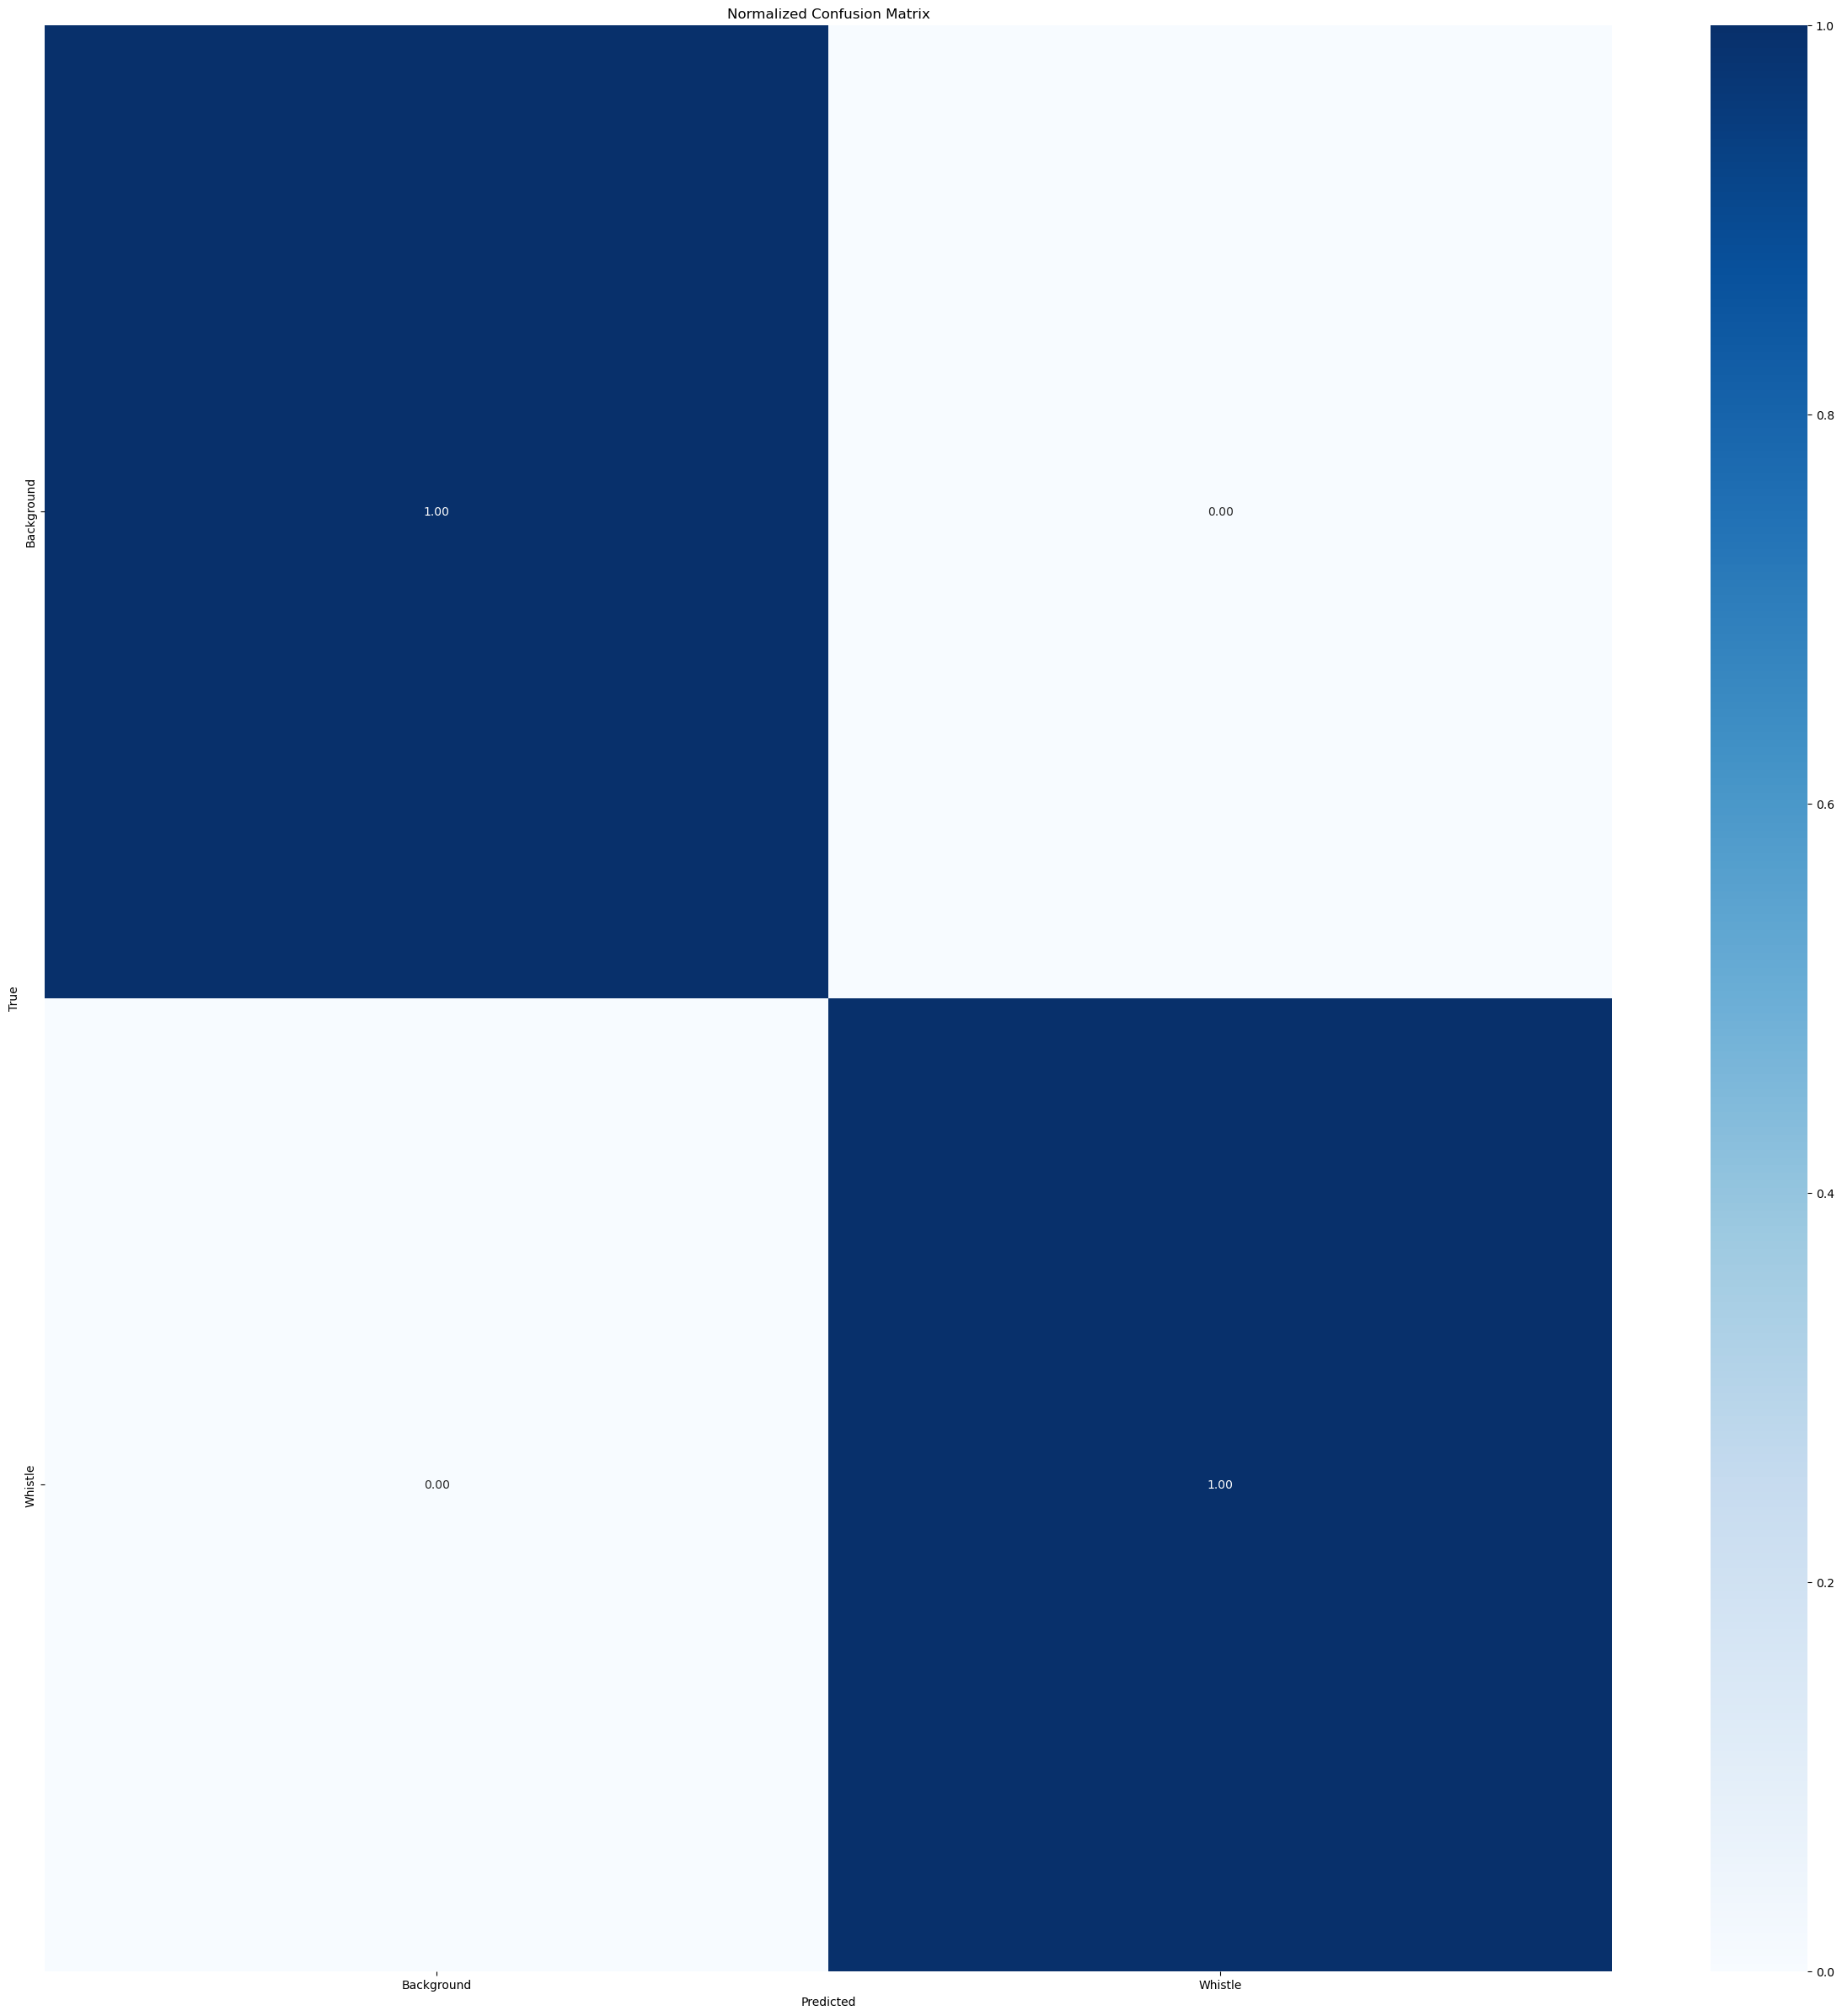

Accuracy: 0.9982
Macro F1-score: 0.9982
Weighted F1-score: 0.9982
Macro ROC-AUC Score: 1.0000


In [51]:
# from each prediction, take the class with the highest probability
pred_classes = [birdnet.classes[i] for i in preds.argmax(axis=1)]

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Convert one-hot encoded test_labels to a list of class labels
true_classes = test_labels.idxmax(axis=1)  # Get class name with highest value (True)
# Generate classification report
report = classification_report(true_classes, pred_classes)
print(report)

# Plot confusion matrix
cm = confusion_matrix(true_classes, pred_classes, labels=test_labels.columns)
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_labels.columns, yticklabels=test_labels.columns)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

import numpy as np

# Normalized by rows
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(30, 30))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=test_labels.columns, yticklabels=test_labels.columns)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

accuracy = accuracy_score(true_classes, pred_classes)
print(f"Accuracy: {accuracy:.4f}")

from sklearn.metrics import f1_score

macro_f1 = f1_score(true_classes, pred_classes, average="macro")
weighted_f1 = f1_score(true_classes, pred_classes, average="weighted")

print(f"Macro F1-score: {macro_f1:.4f}")
print(f"Weighted F1-score: {weighted_f1:.4f}")

from sklearn.metrics import roc_auc_score

# Assuming 'preds' contains raw probabilities from the classifier
auc_score = roc_auc_score(test_labels.values, preds, average="macro", multi_class="ovr")
print(f"Macro ROC-AUC Score: {auc_score:.4f}")

#### WOPAM

In [53]:
wopam_labels = load_labels_from_df(df_wopam_day)

  0%|          | 0/10 [00:00<?, ?it/s]

/home/gruncrow/anaconda3/envs/bmz/lib/python3.10/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 1.0 sec instead of 2.97 sec
  warnings.warn(error_msg)


              precision    recall  f1-score   support

  Background       0.96      0.67      0.79       150
     Whistle       0.04      0.33      0.07         6

    accuracy                           0.65       156
   macro avg       0.50      0.50      0.43       156
weighted avg       0.93      0.65      0.76       156



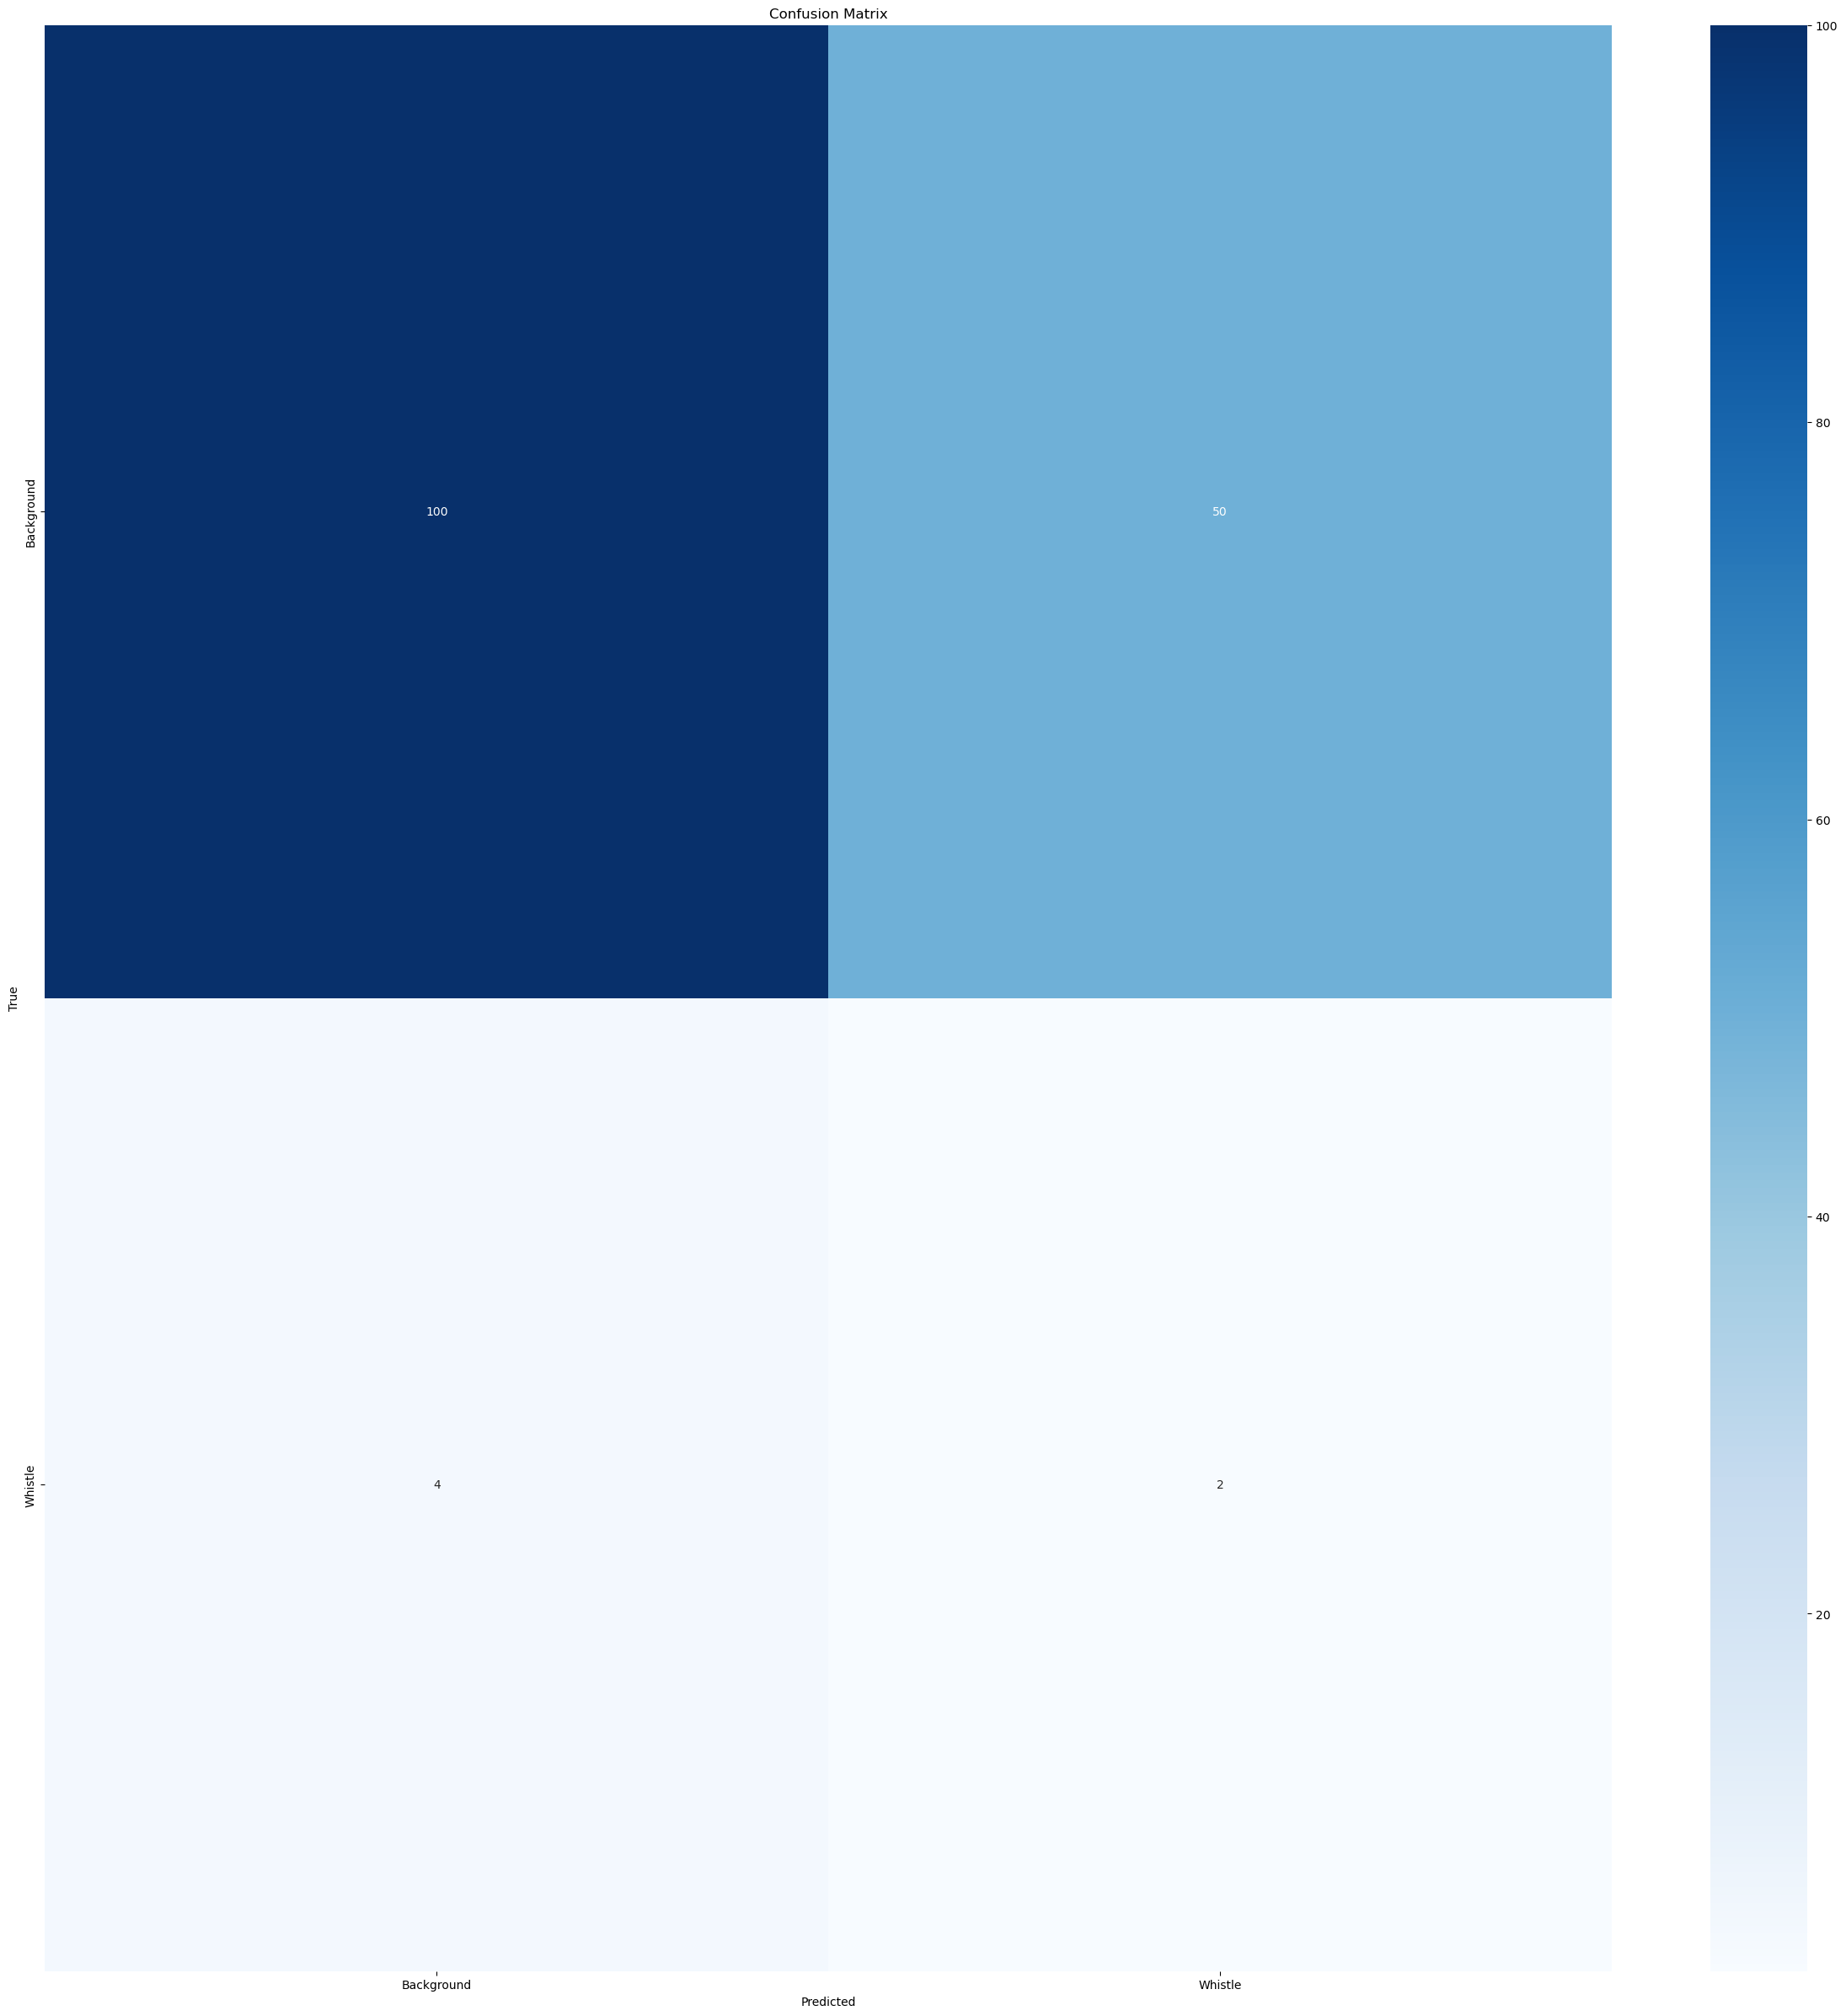

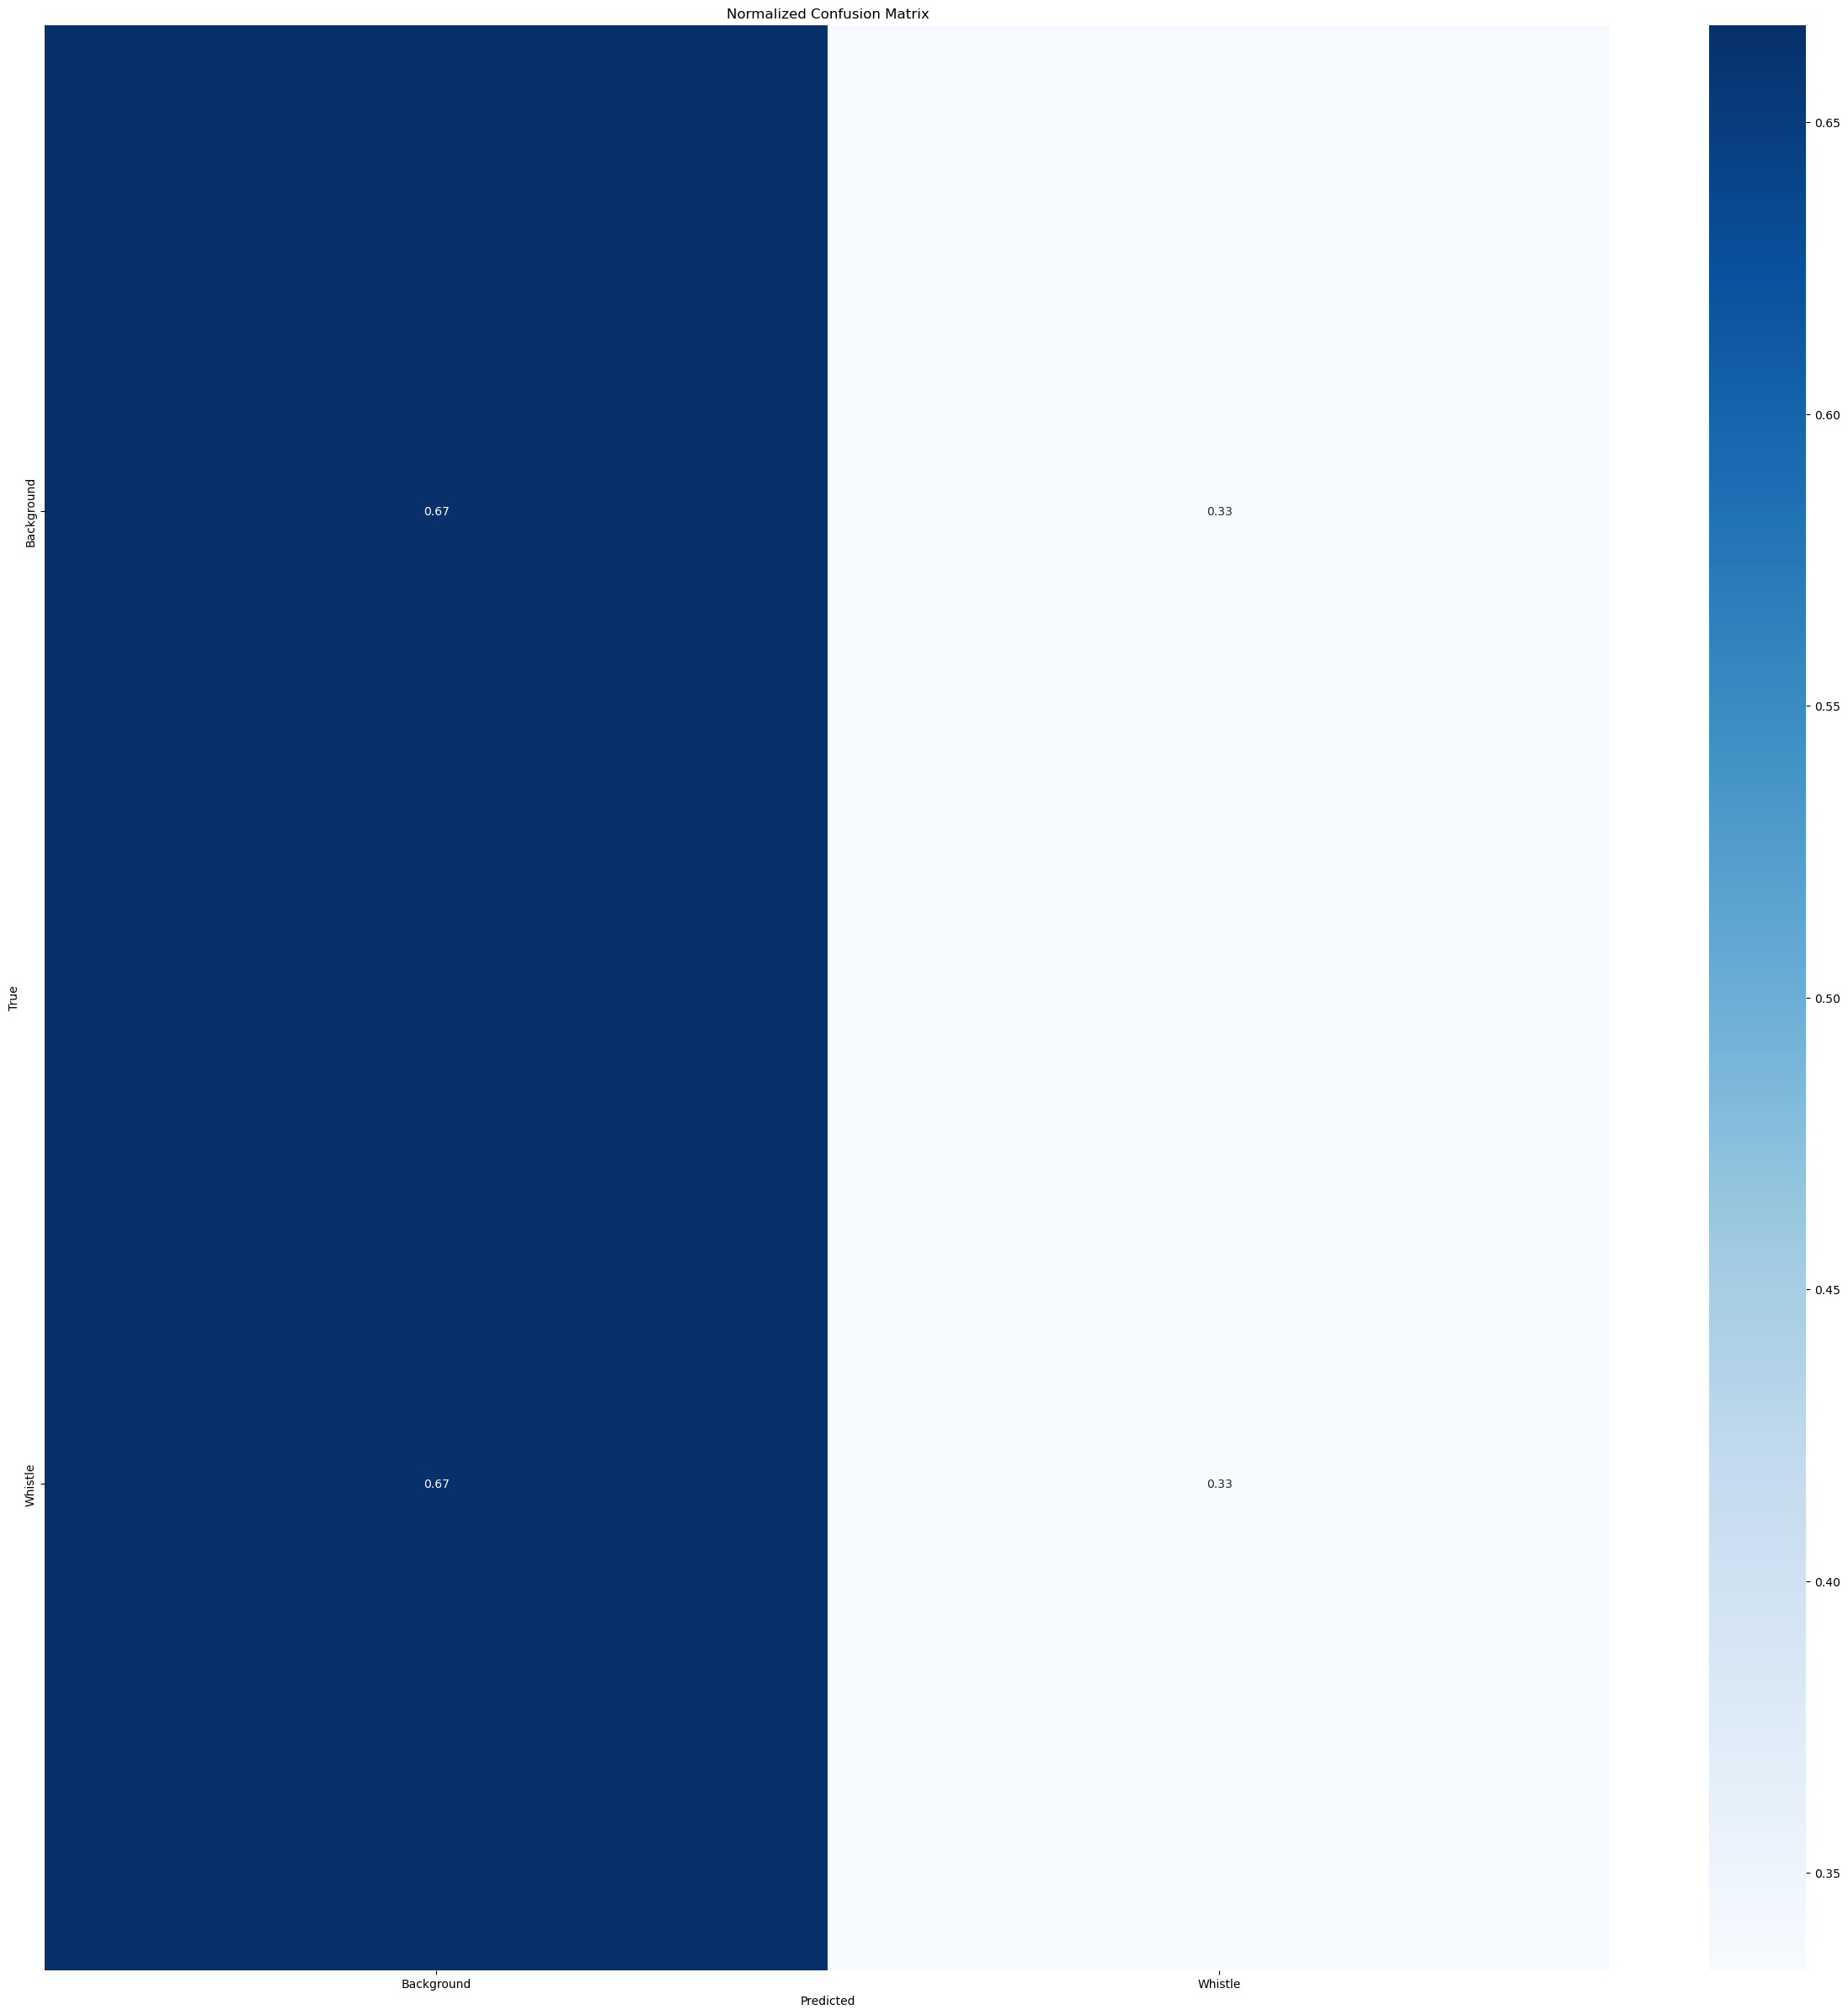

In [54]:
wopam_emb = birdnet.embed(wopam_labels, return_dfs=False, batch_size=16, num_workers=0)
# make predictions by passing the embeddings through the classifier
preds = birdnet.network(torch.tensor(wopam_emb).float()).detach().numpy()
# from each prediction, take the class with the highest probability
pred_classes = [birdnet.classes[i] for i in preds.argmax(axis=1)]

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Convert one-hot encoded wopam_labels to a list of class labels
true_classes = wopam_labels.idxmax(axis=1)  # Get class name with highest value (True)
# Generate classification report
report = classification_report(true_classes, pred_classes, labels=birdnet.classes)
print(report)

# Plot confusion matrix
cm = confusion_matrix(true_classes, pred_classes, labels=birdnet.classes)
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=birdnet.classes, yticklabels=birdnet.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

import numpy as np

# Normalized by rows
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(30, 30))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=birdnet.classes, yticklabels=birdnet.classes)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Use BirdNET embeddings with RandomForest

In [55]:
# take a RandomForest classifier
from sklearn.ensemble import RandomForestClassifier

# create several experiments for RandomForest classifier and select the best one in validation
n_estimators = [10, 50, 100, 200]
max_depth = [10, 20, 50]
best_score = 0
best_clf = None

for n in n_estimators:
    for d in max_depth:
        clf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=42)
        clf.fit(emb_train, train_labels.values)
        preds = clf.predict(emb_val)
        # score = macro average f1
        score = f1_score(val_labels.values.argmax(axis=1), preds.argmax(axis=1), average='macro')
        if score > best_score:
            best_score = score
            best_clf = clf

# print the best parameters
print(best_clf)

RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42)


#### Test

              precision    recall  f1-score   support

  Background       0.99      0.98      0.99       725
     Whistle       0.99      1.00      0.99       925

    accuracy                           0.99      1650
   macro avg       0.99      0.99      0.99      1650
weighted avg       0.99      0.99      0.99      1650



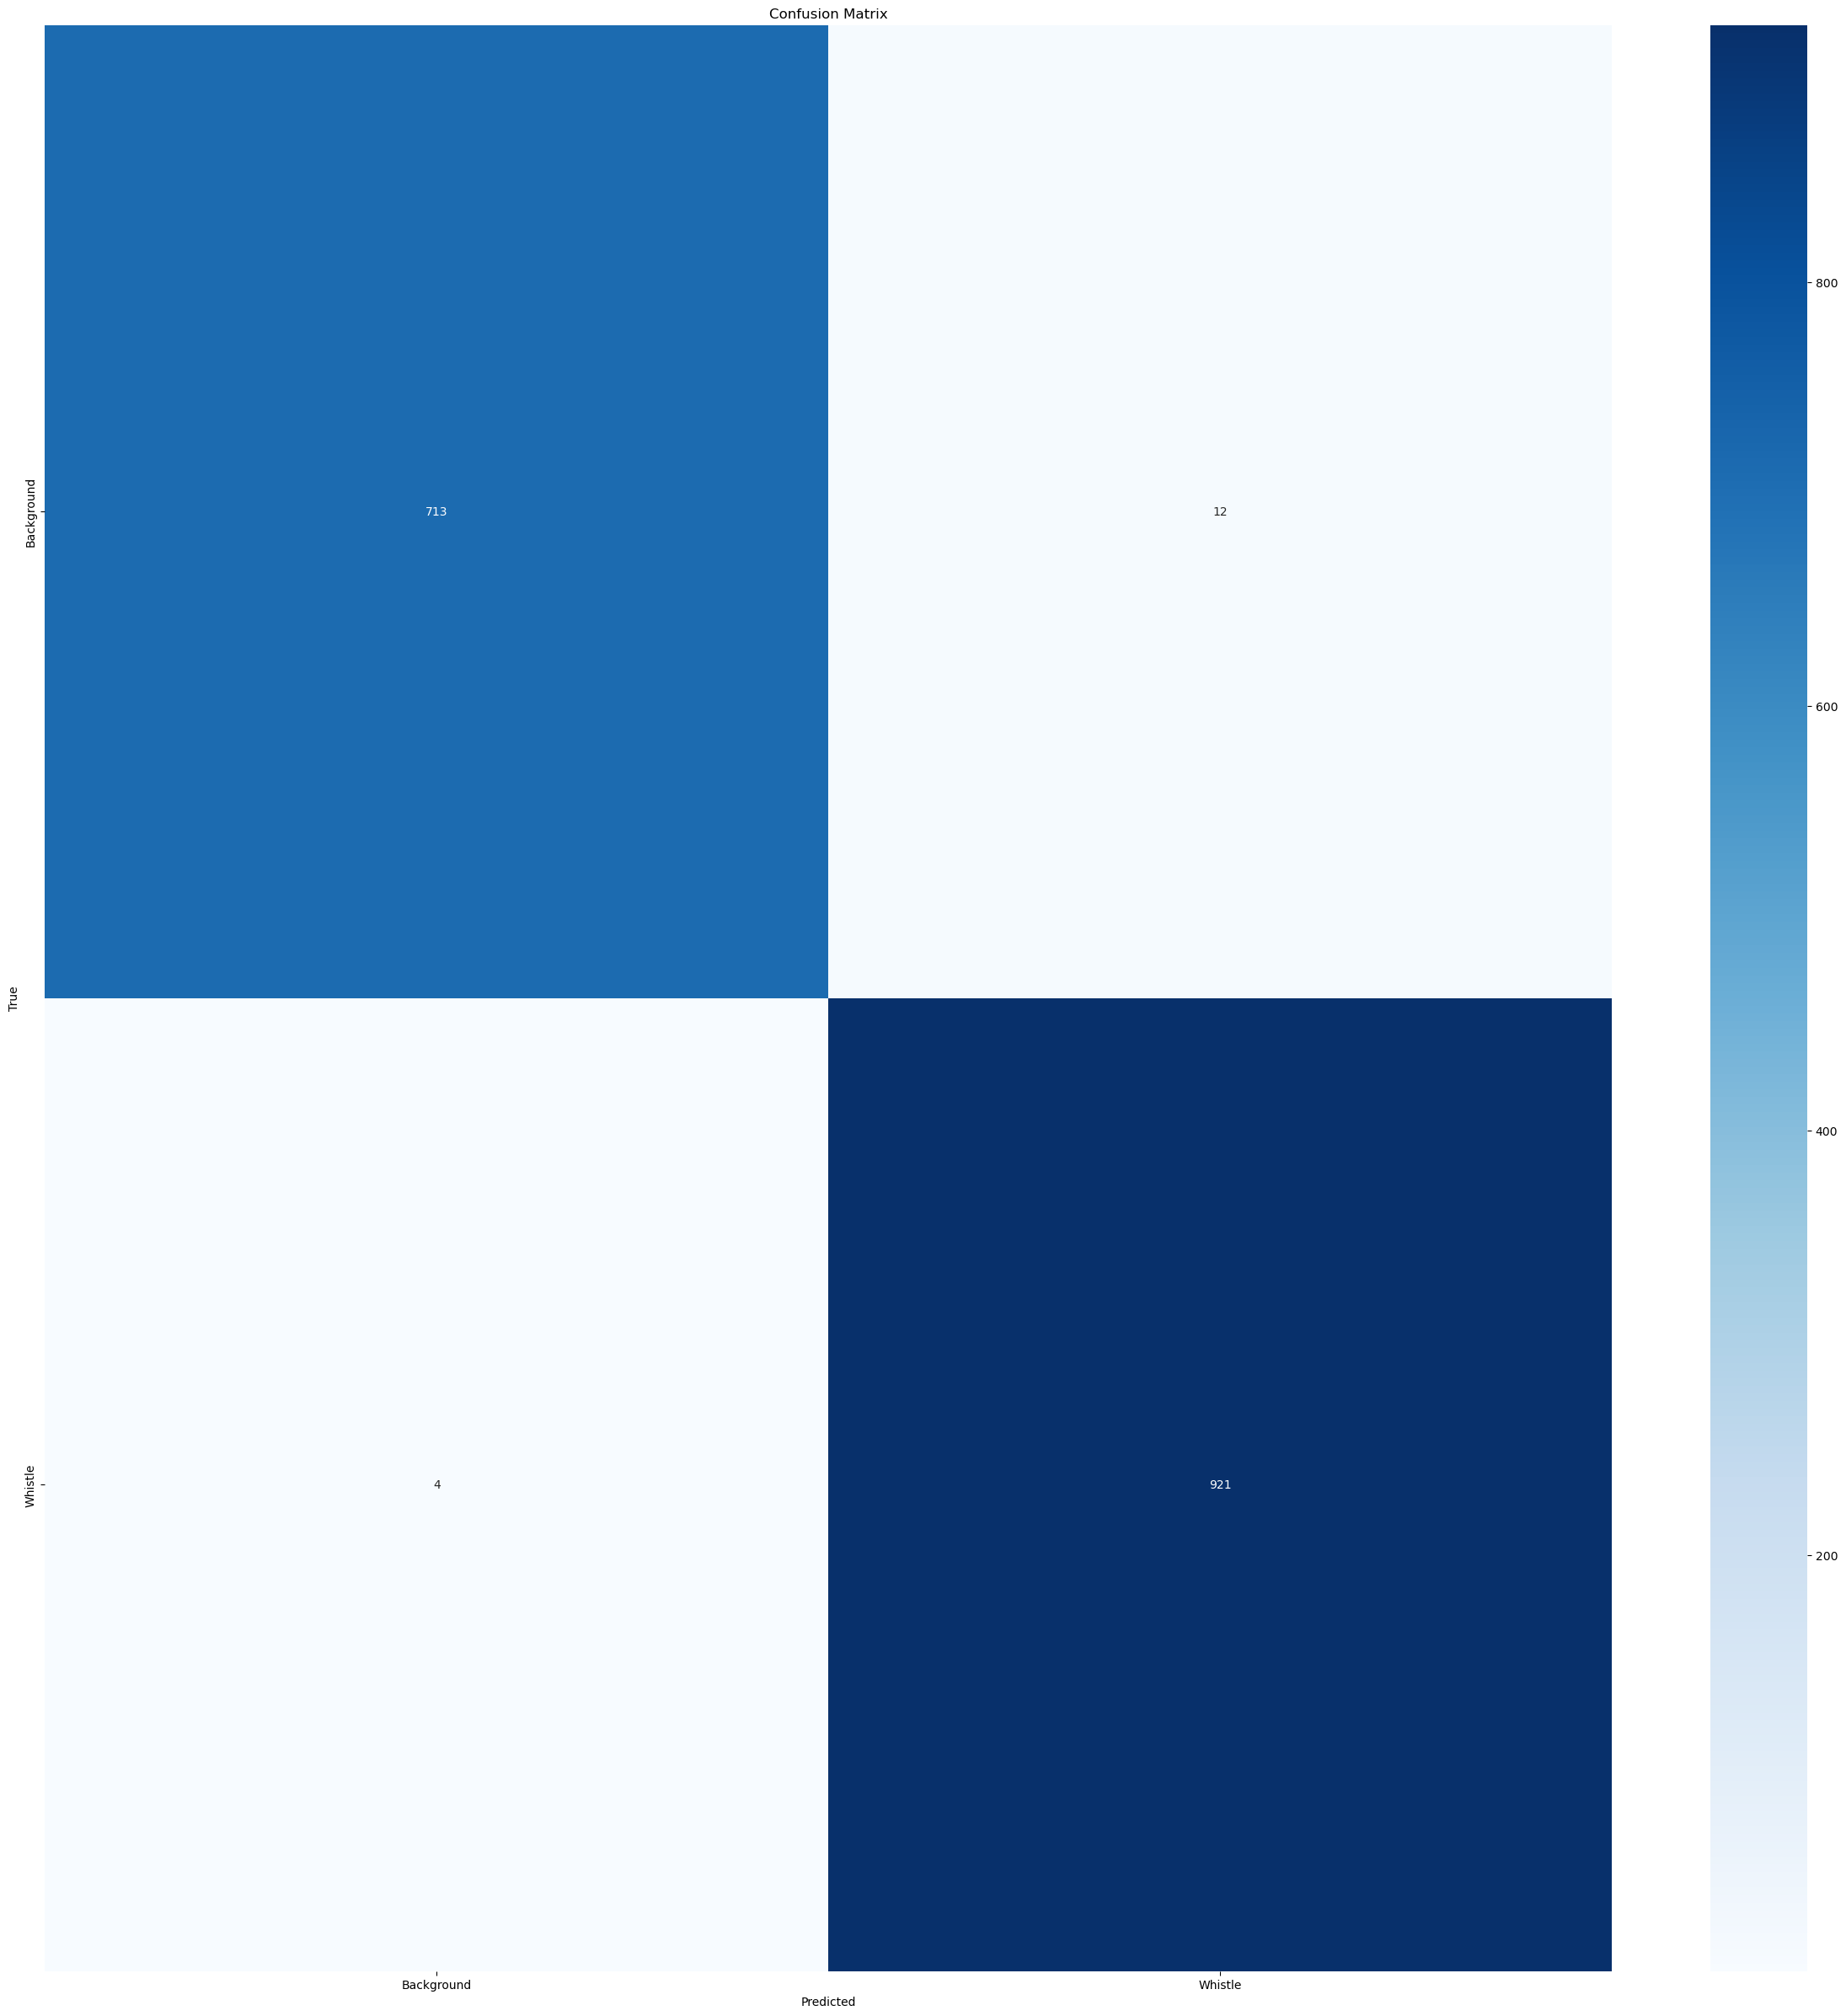

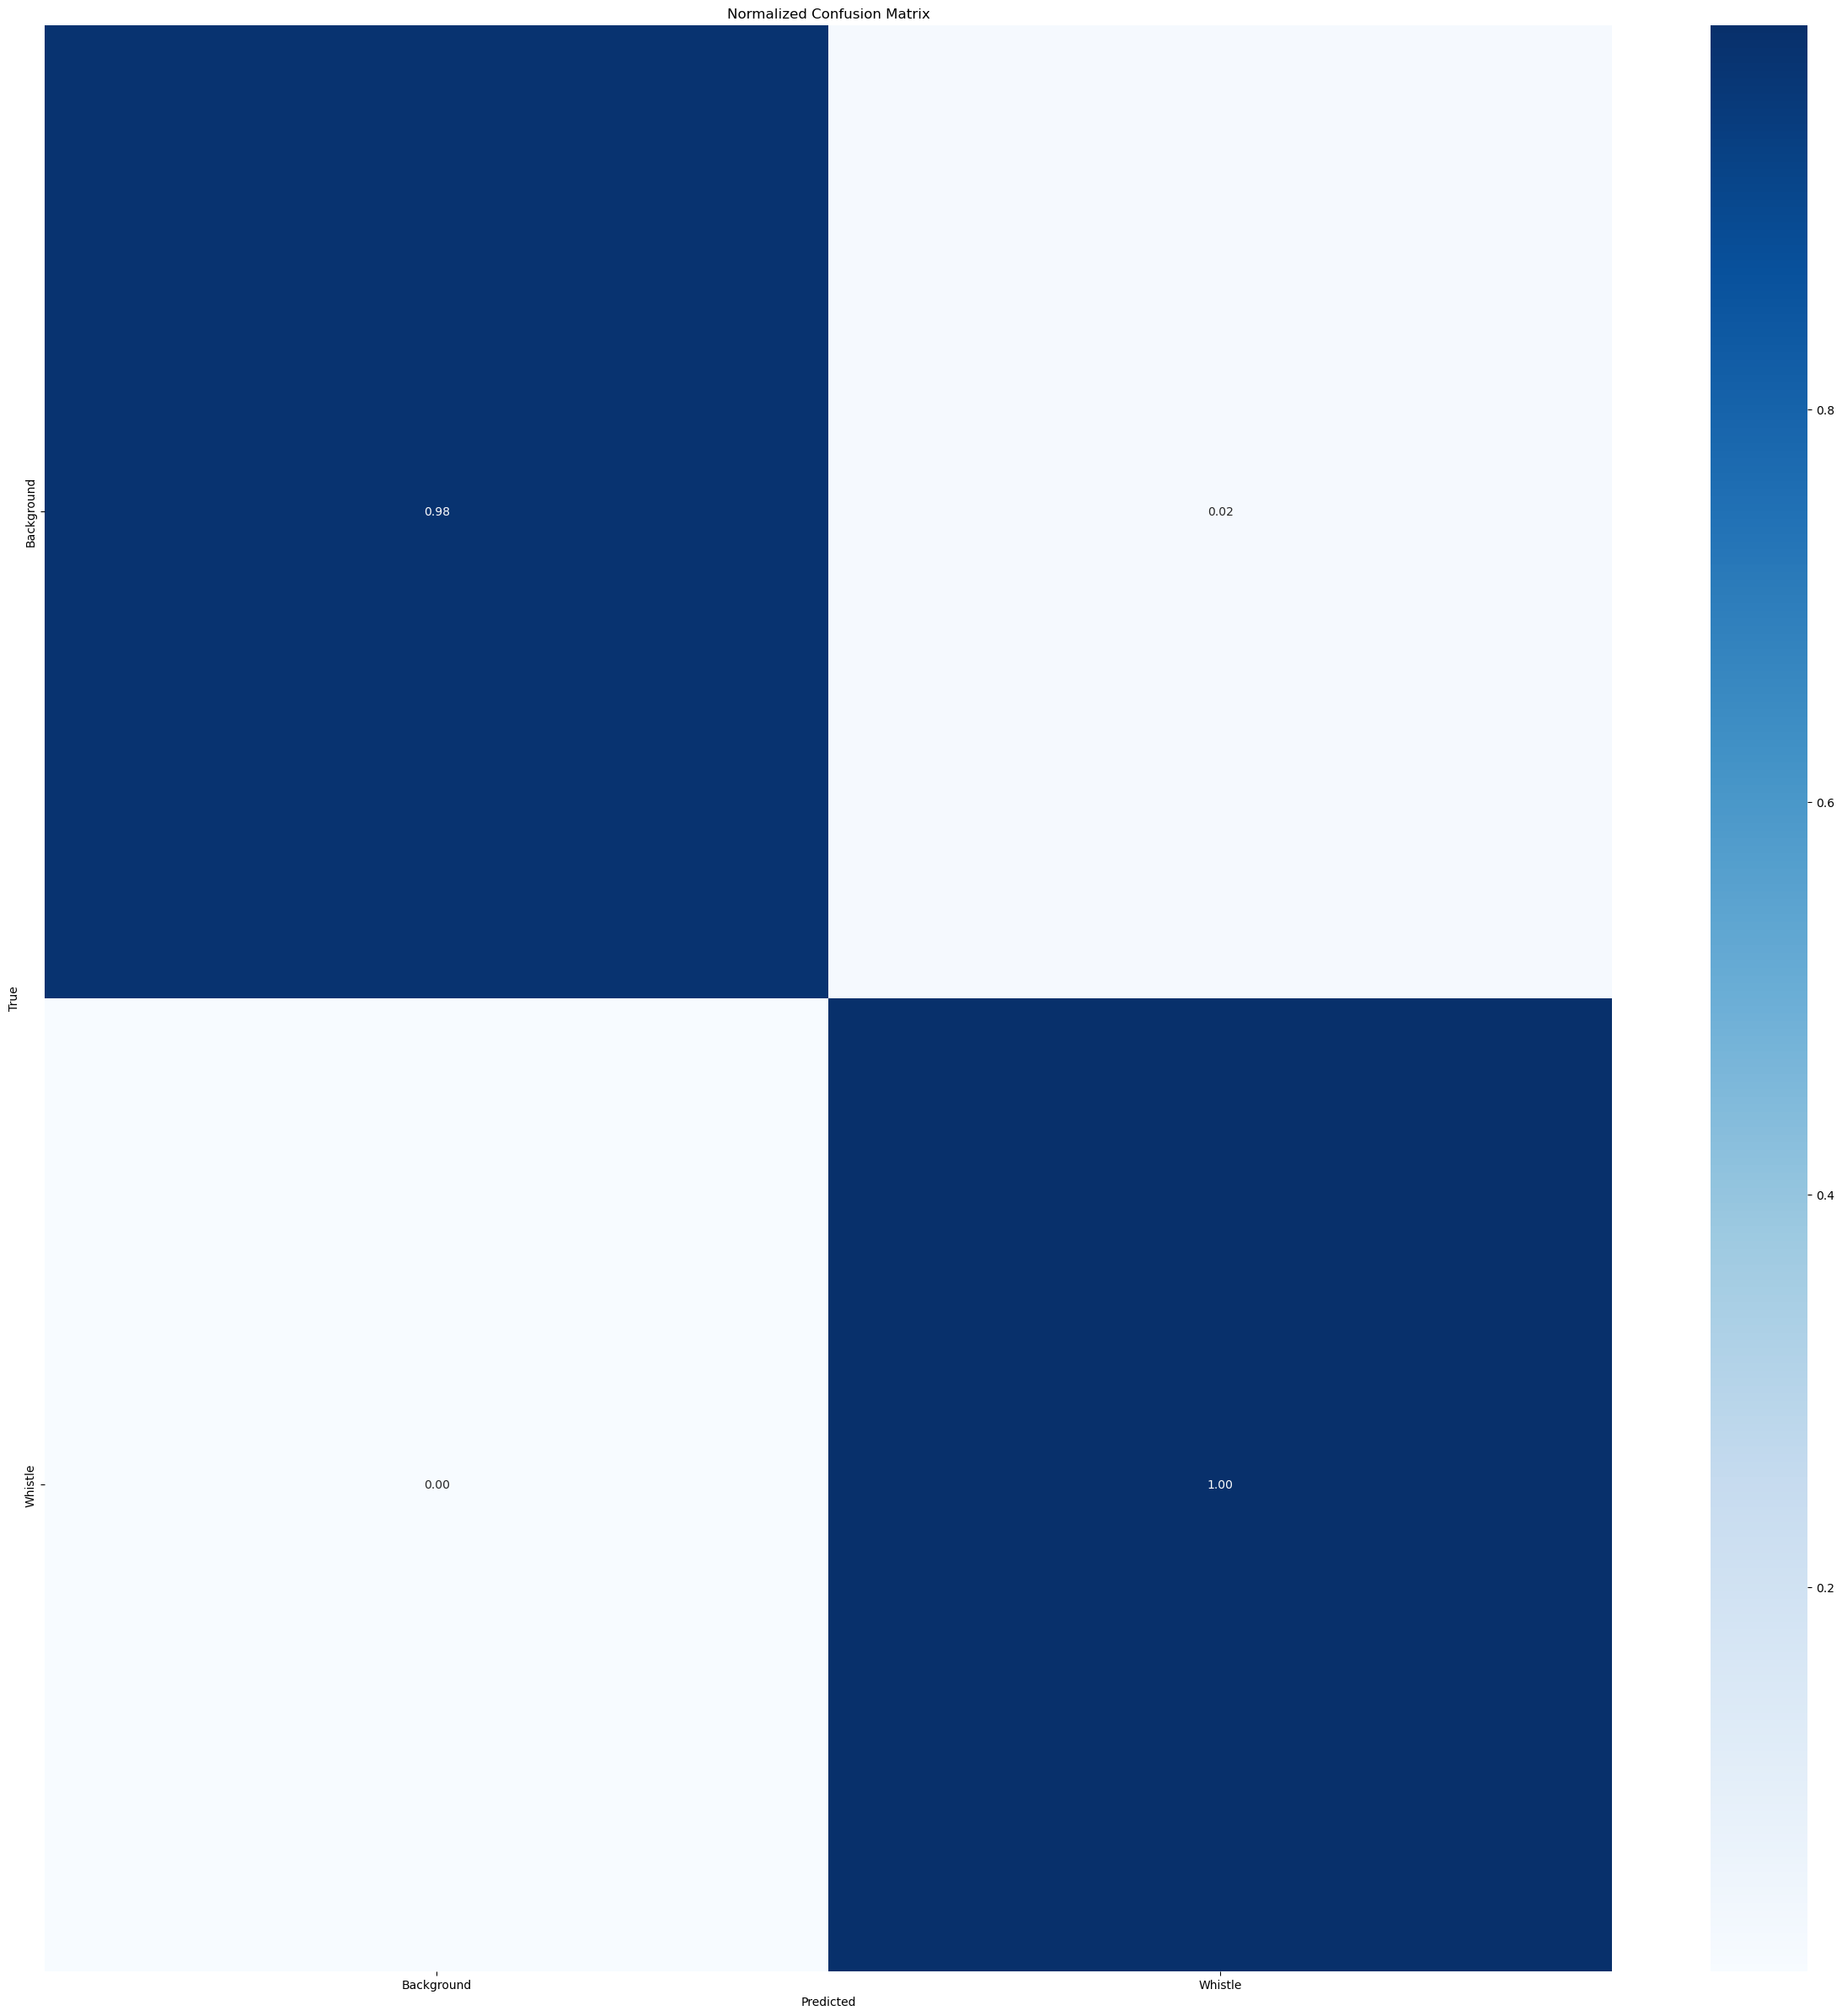

Accuracy: 0.9903
Macro F1-score: 0.9901
Weighted F1-score: 0.9903
Macro ROC-AUC Score: 0.9896


In [ ]:
# make predictions on the validation set
preds = best_clf.predict(emb_test)

# from each prediction, take the class with the highest probability
pred_classes = [birdnet.classes[i] for i in preds.argmax(axis=1)]

# Convert one-hot encoded test_labels to a list of class labels
true_classes = test_labels.idxmax(axis=1)  # Get class name with highest value (True)
# Generate classification report
report = classification_report(true_classes, pred_classes)
print(report)

# Plot confusion matrix
cm = confusion_matrix(true_classes, pred_classes, labels=test_labels.columns)
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_labels.columns, yticklabels=test_labels.columns)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Normalized by rows
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(30, 30))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=test_labels.columns, yticklabels=test_labels.columns)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

accuracy = accuracy_score(true_classes, pred_classes)
print(f"Accuracy: {accuracy:.4f}")

macro_f1 = f1_score(true_classes, pred_classes, average="macro")
weighted_f1 = f1_score(true_classes, pred_classes, average="weighted")

print(f"Macro F1-score: {macro_f1:.4f}")
print(f"Weighted F1-score: {weighted_f1:.4f}")

# Assuming 'preds' contains raw probabilities from the classifier
auc_score = roc_auc_score(test_labels.values, preds, average="macro", multi_class="ovr")
print(f"Macro ROC-AUC Score: {auc_score:.4f}")


#### WOPAM

              precision    recall  f1-score   support

  Background       0.95      0.49      0.64       150
     Whistle       0.03      0.33      0.05         6

    accuracy                           0.48       156
   macro avg       0.49      0.41      0.35       156
weighted avg       0.91      0.48      0.62       156



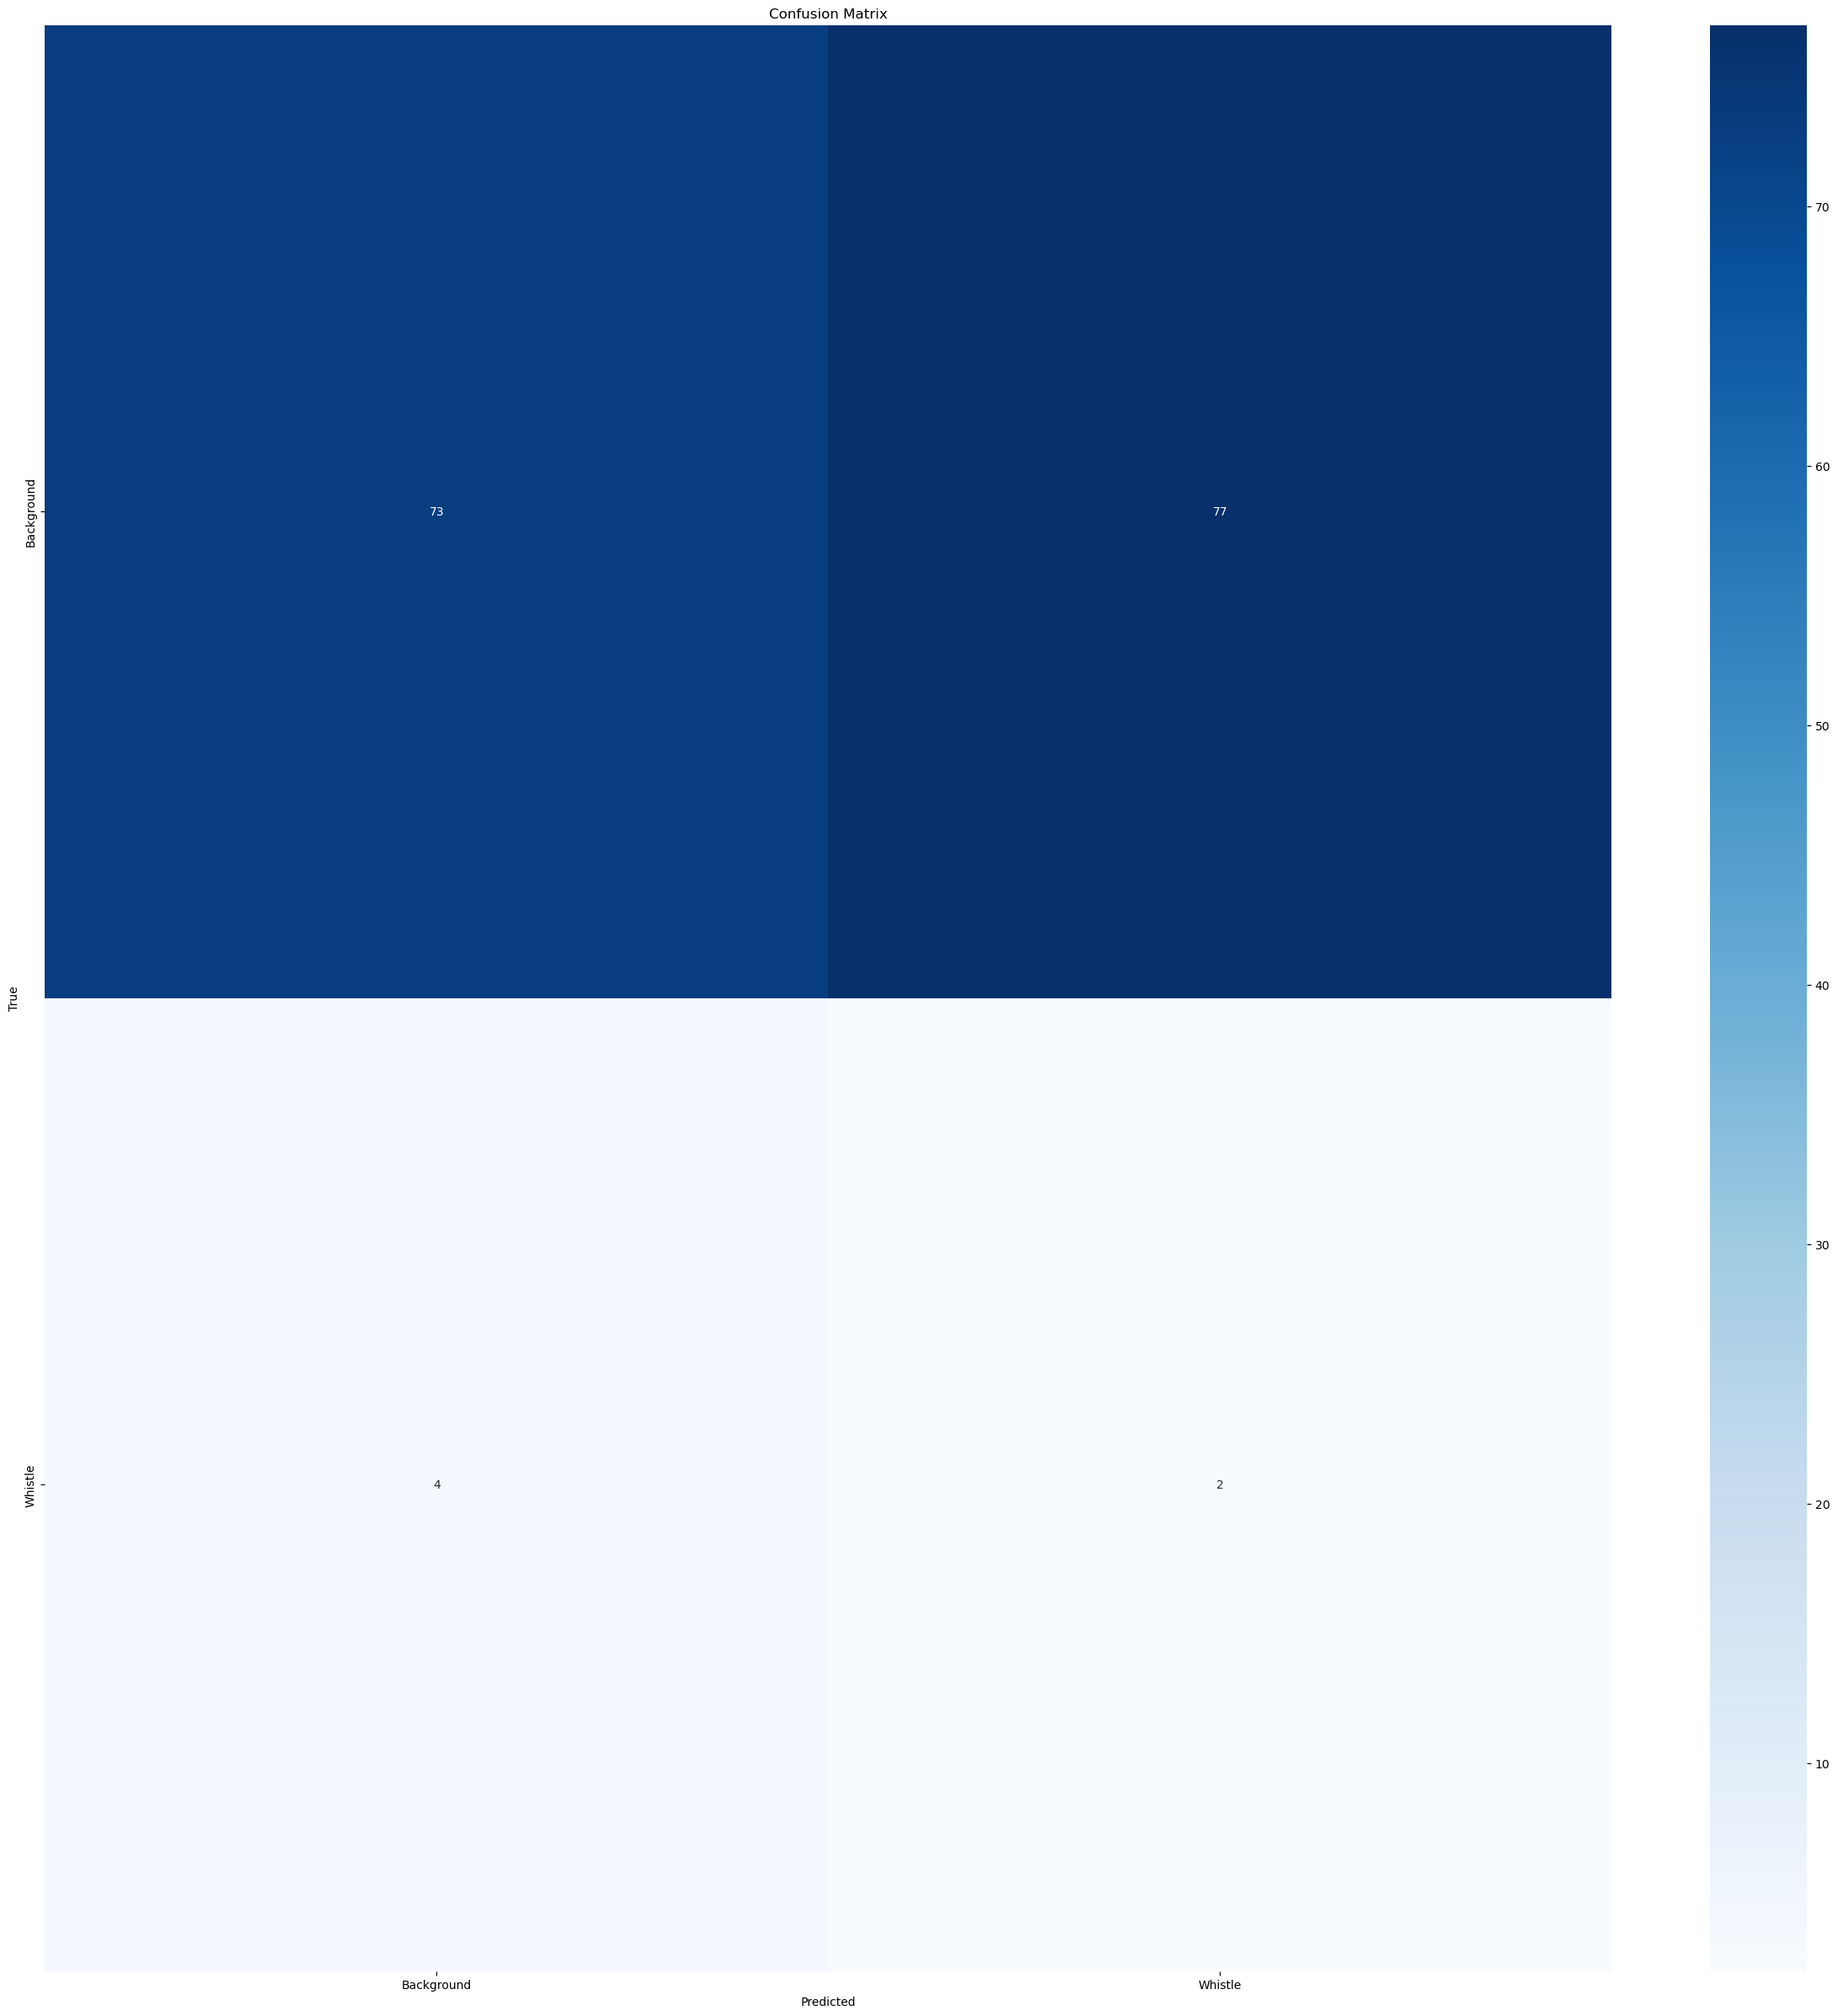

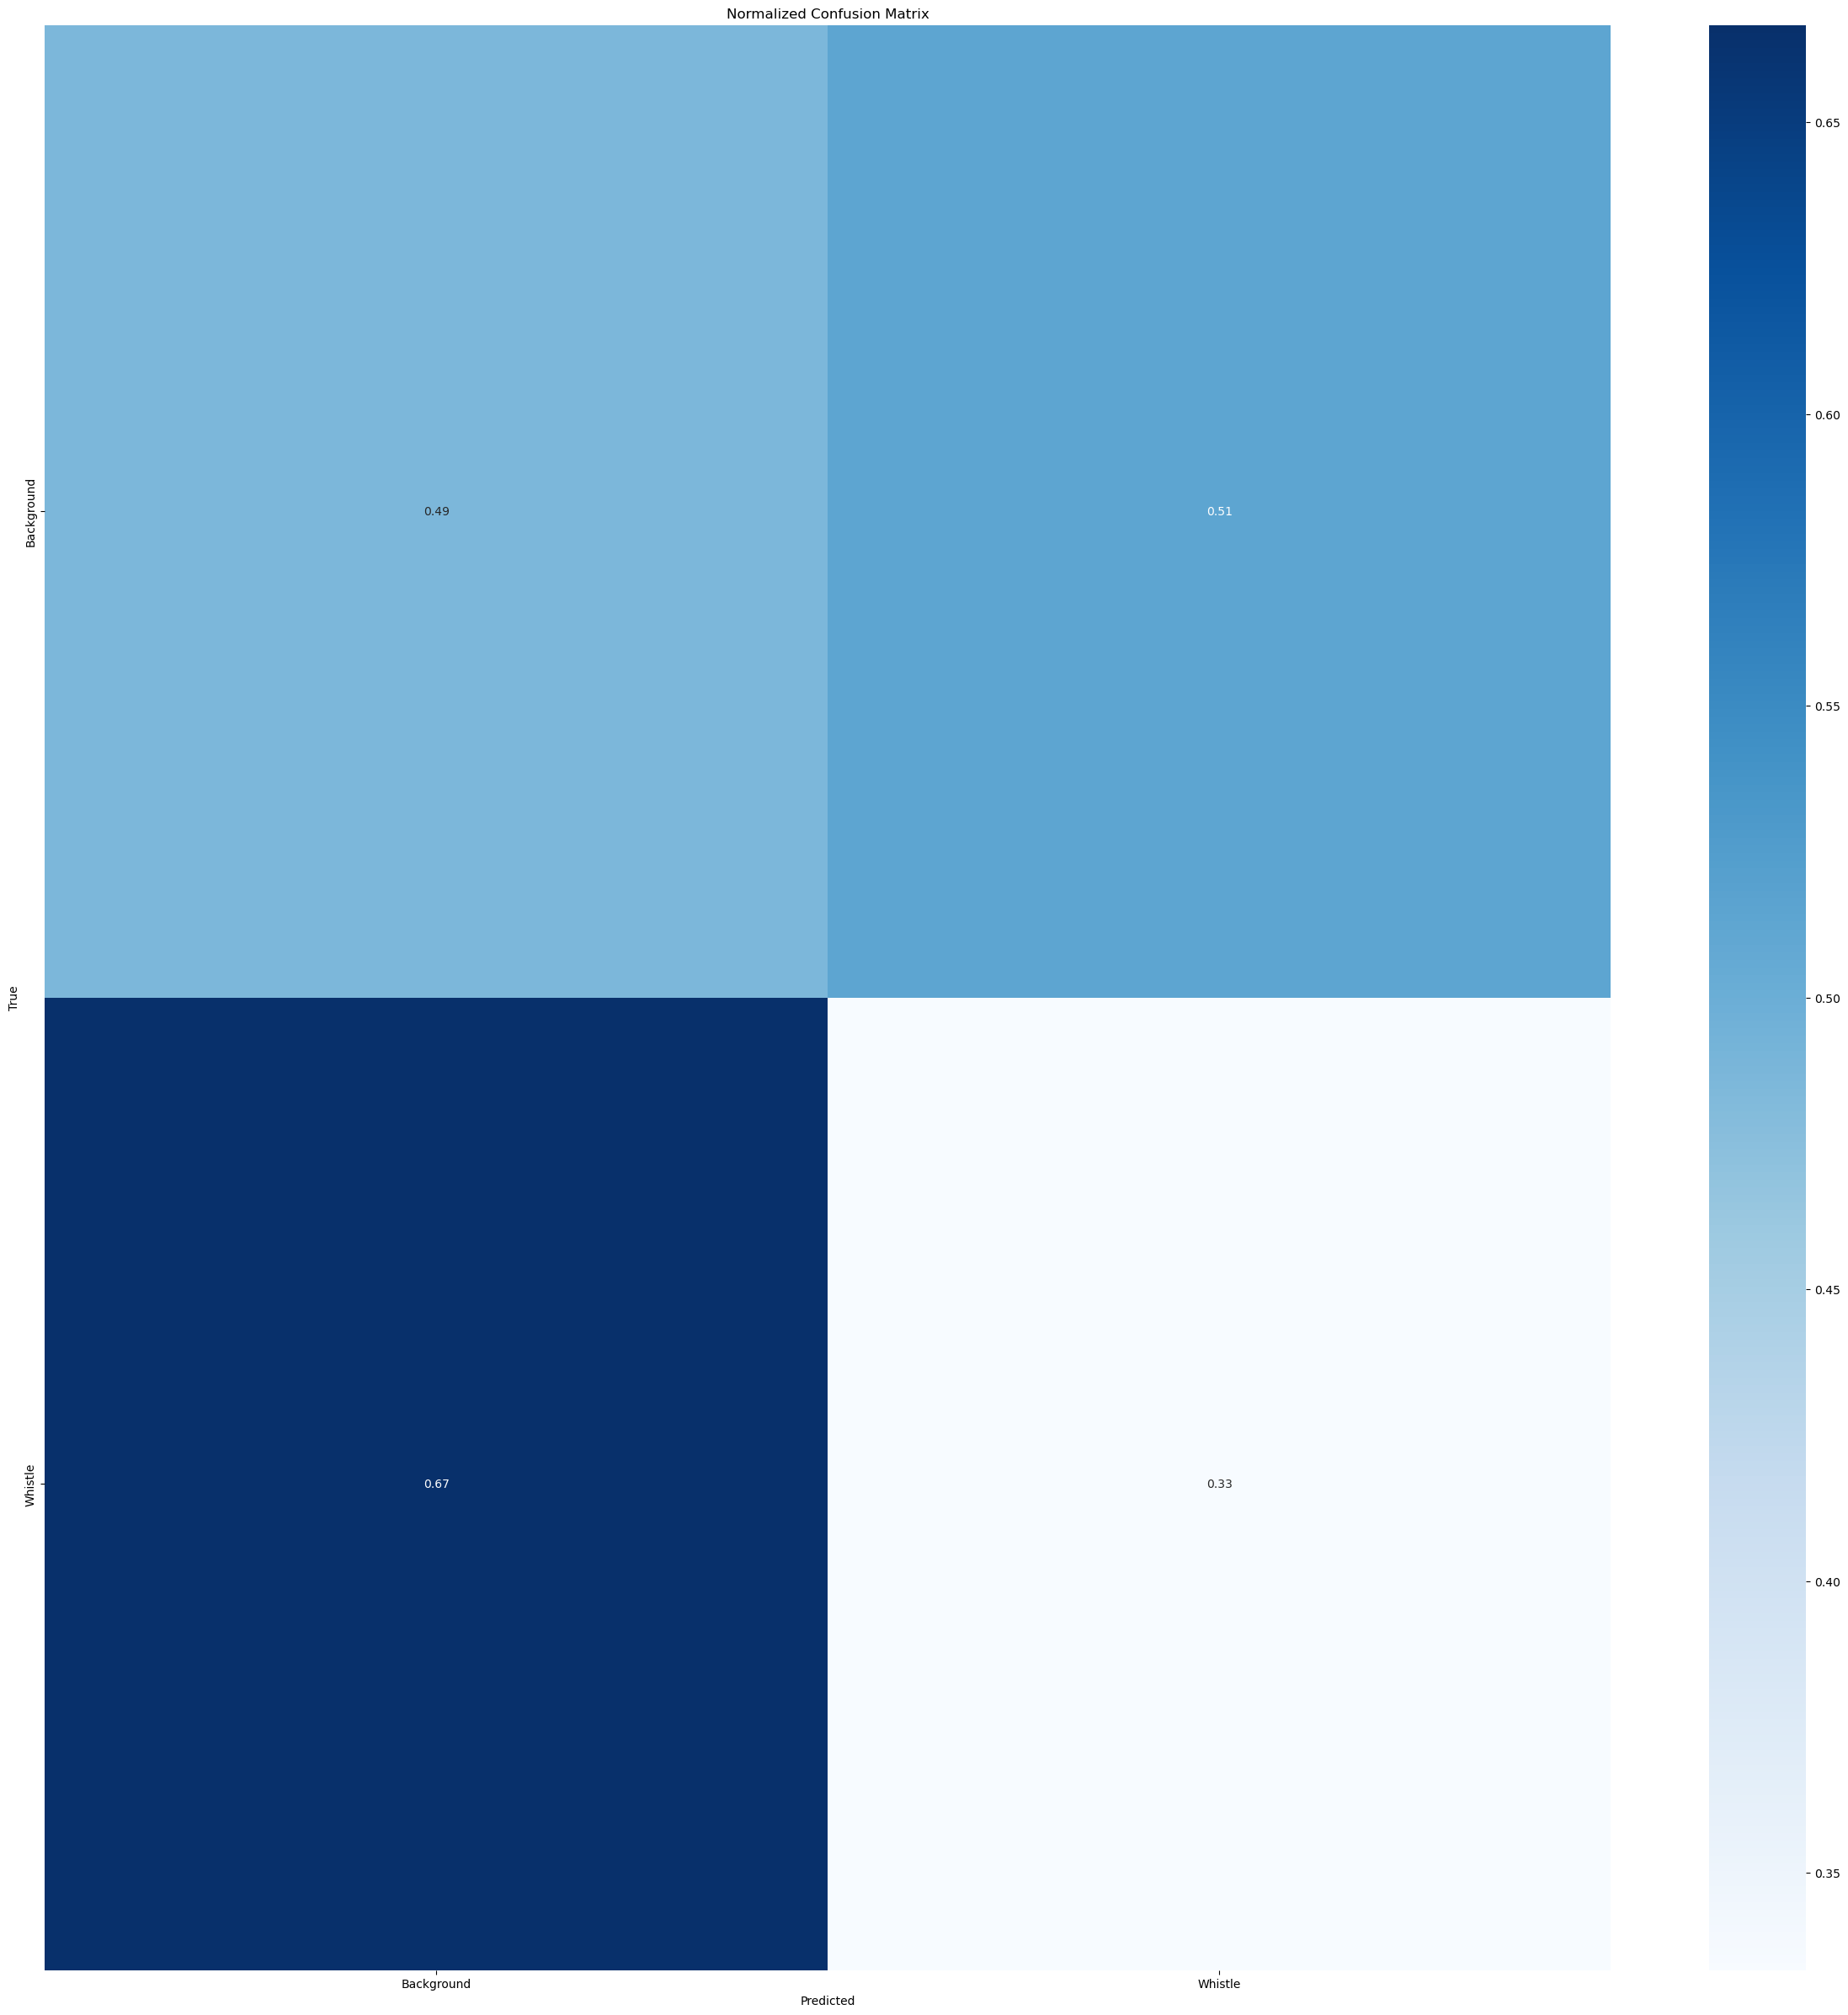

In [57]:
# test random forest on wopam
preds = best_clf.predict(wopam_emb)
# from each prediction, take the class with the highest probability
pred_classes = [birdnet.classes[i] for i in preds.argmax(axis=1)]

# Convert one-hot encoded wopam_labels to a list of class labels
true_classes = wopam_labels.idxmax(axis=1)  # Get class name with highest value (True)
# Generate classification report
report = classification_report(true_classes, pred_classes, labels=birdnet.classes)
print(report)

# Plot confusion matrix
cm = confusion_matrix(true_classes, pred_classes, labels=birdnet.classes)
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=birdnet.classes, yticklabels=birdnet.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Normalized by rows
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(30, 30))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=birdnet.classes, yticklabels=birdnet.classes)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Use BirdNET embeddings with SVC-RBF

In [58]:
# take a SVC-RBF classifier
from sklearn.svm import SVC

# create several experiments for SVC classifier and select the best one in validation
C_params = [1, 10, 100]
gamma = [0.1, 0.01, 0.001]
best_score = 0
best_clf = None

for c in C_params:
    for g in gamma:
        clf = SVC(kernel='rbf', C=c, gamma=g, probability=True, random_state=42)
        clf.fit(emb_train, train_labels.values.argmax(axis=1))
        preds = clf.predict(emb_val)
        # score = macro average f1
        score = f1_score(val_labels.values.argmax(axis=1), preds, average='macro')
        if score > best_score:
            best_score = score
            best_clf = clf

# print the best parameters
print(best_clf)

SVC(C=1, gamma=0.001, probability=True, random_state=42)


#### Test

              precision    recall  f1-score   support

  Background       1.00      1.00      1.00       725
     Whistle       1.00      1.00      1.00       925

    accuracy                           1.00      1650
   macro avg       1.00      1.00      1.00      1650
weighted avg       1.00      1.00      1.00      1650



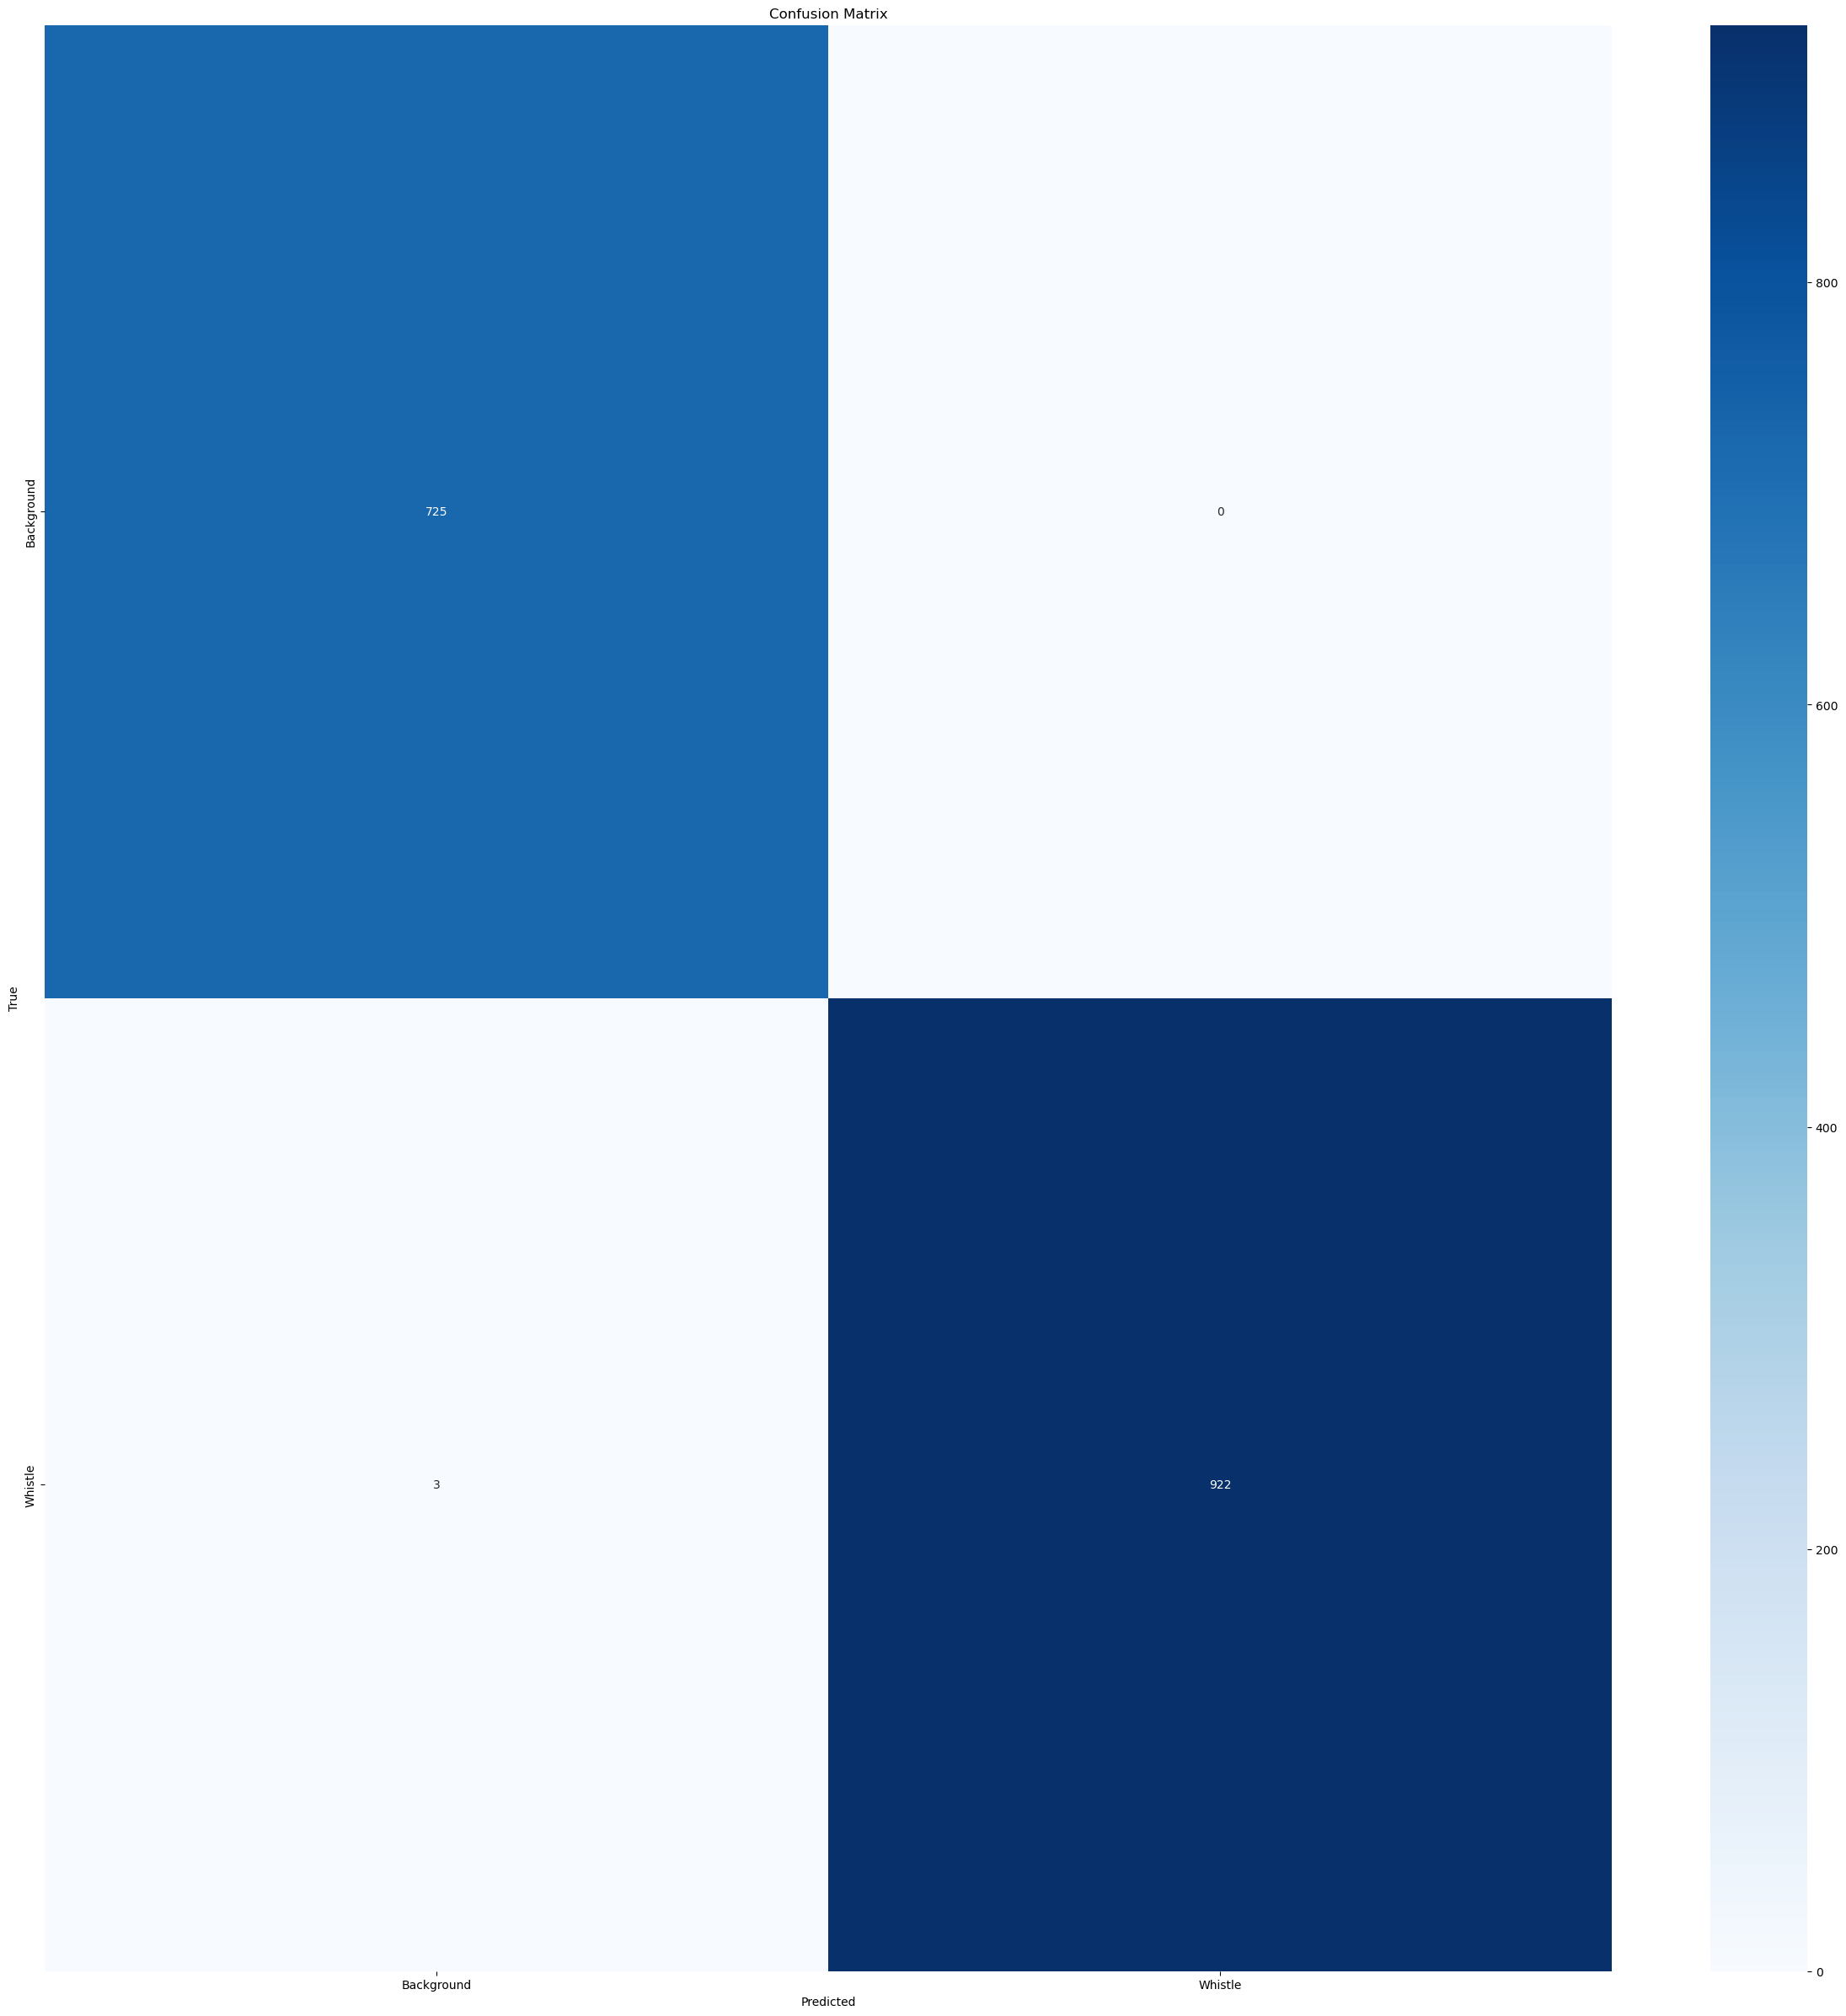

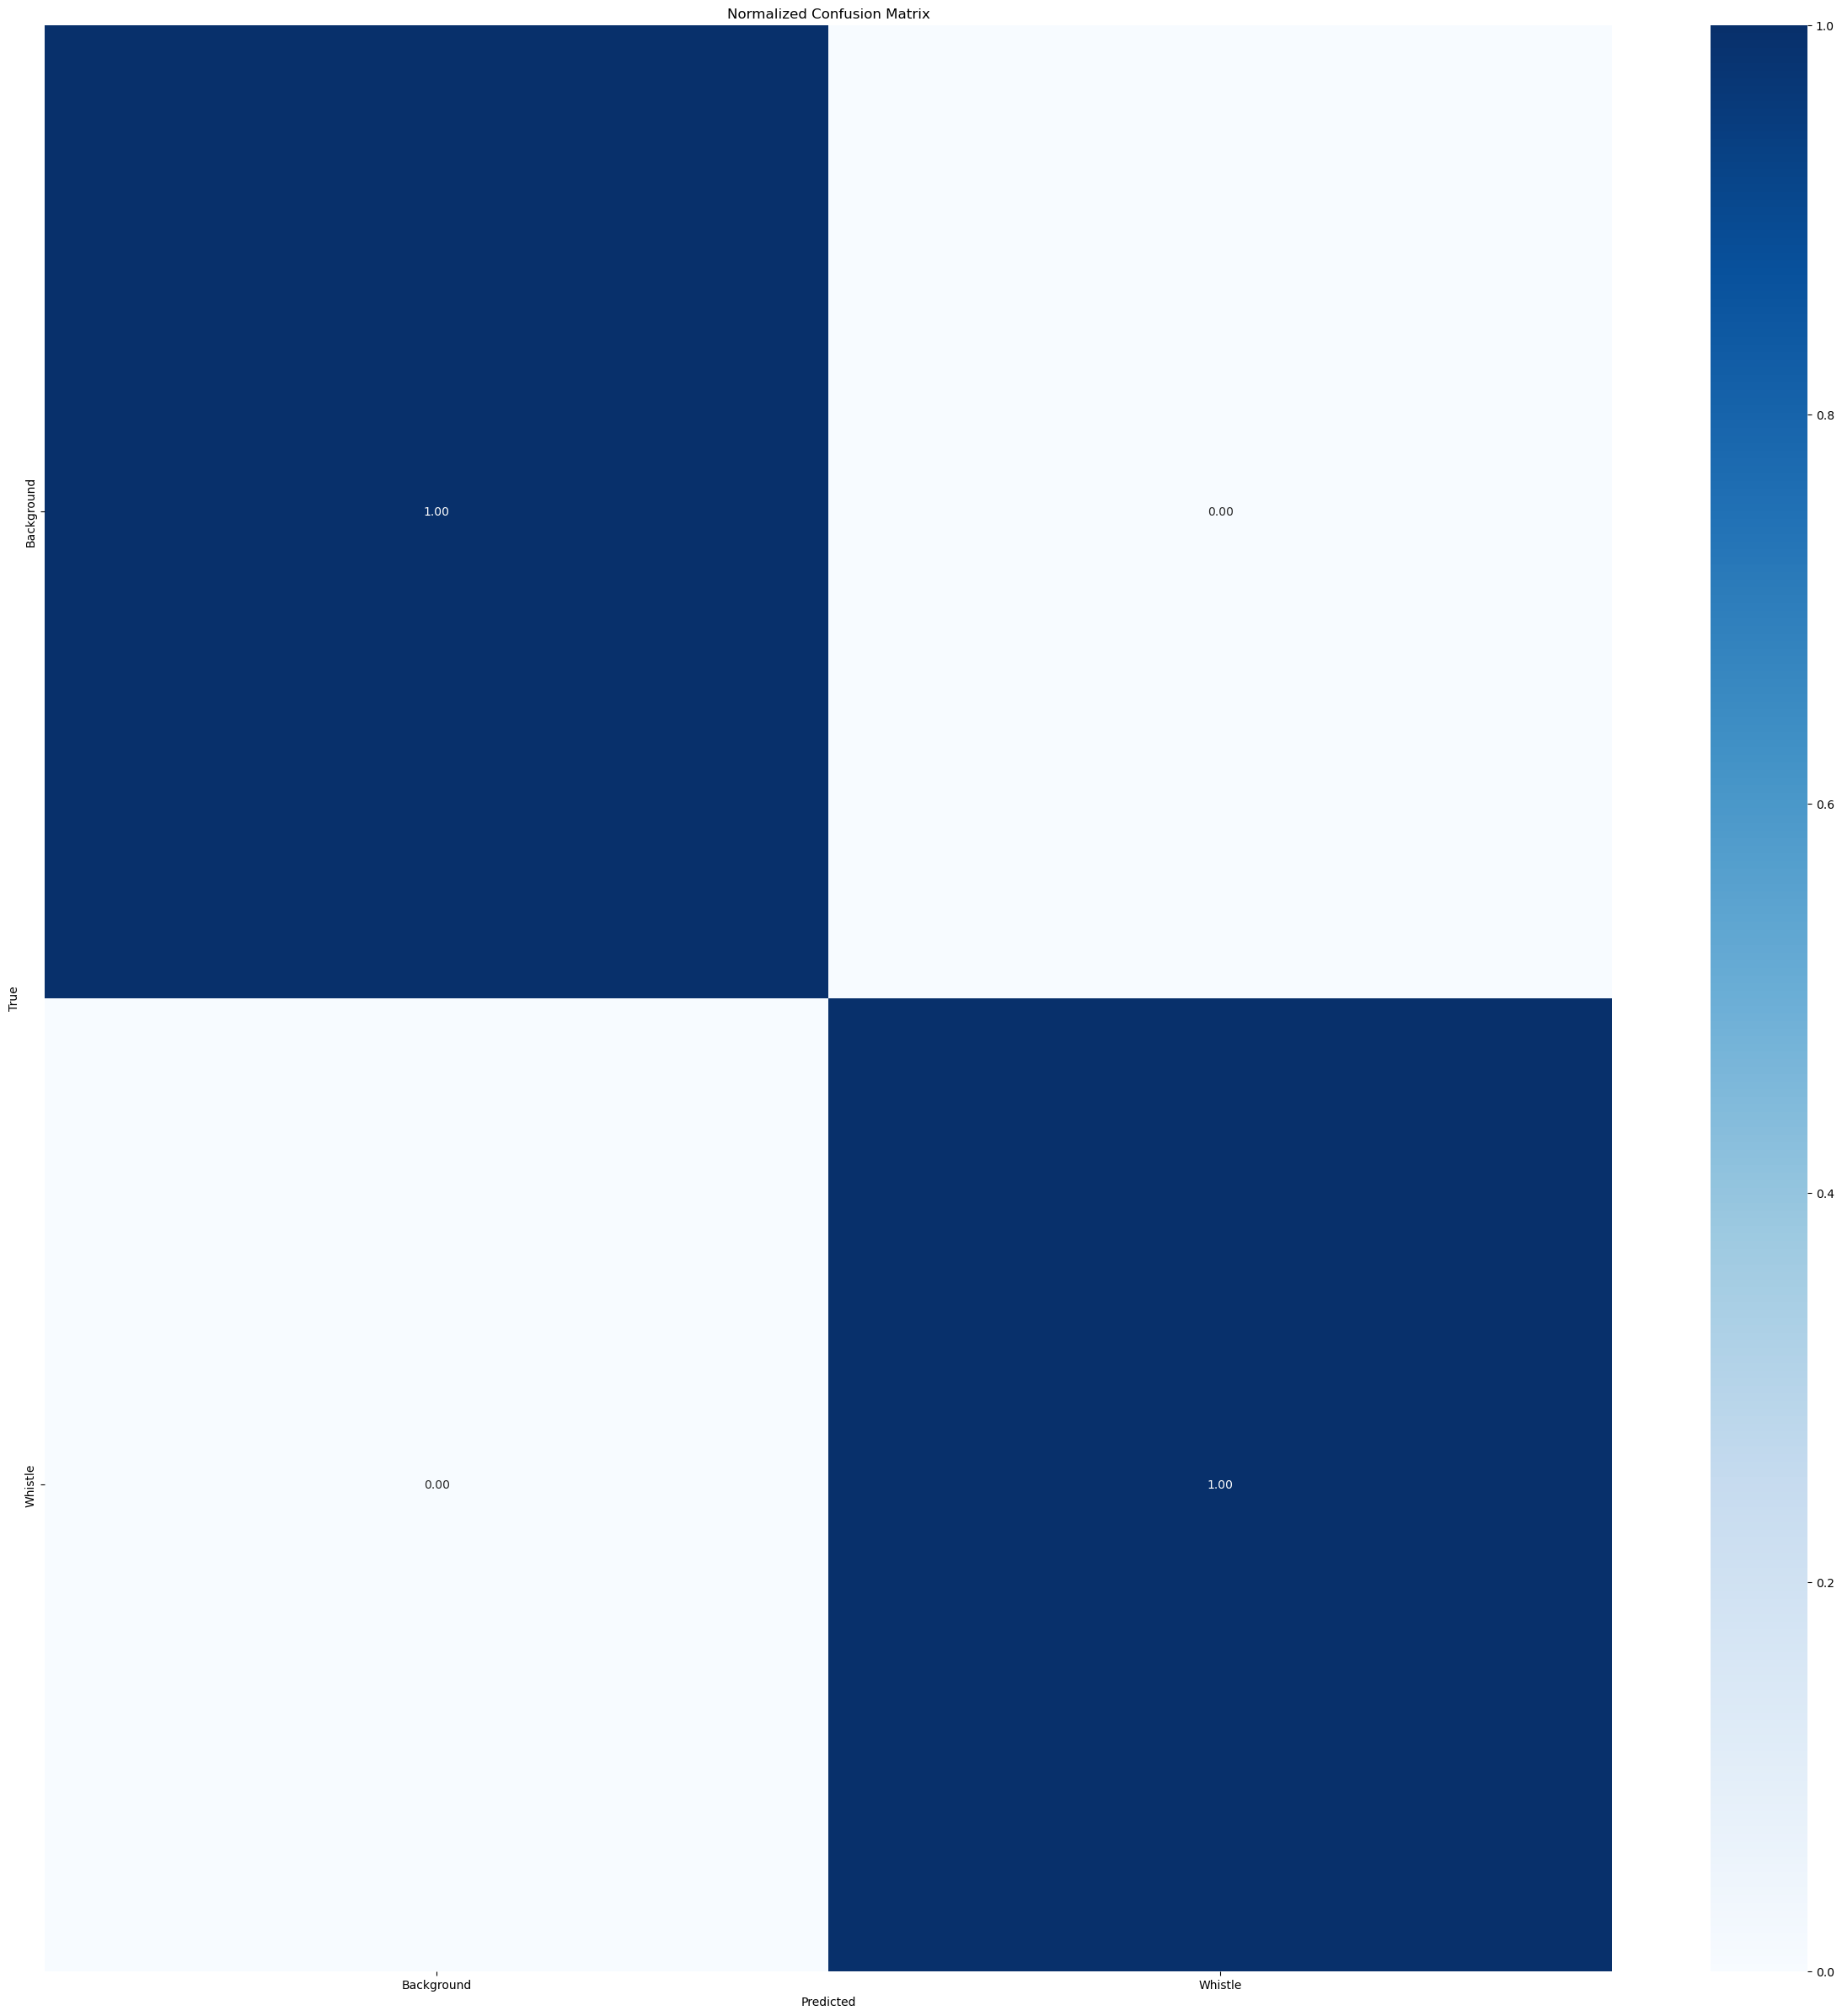

Accuracy: 0.9982
Macro F1-score: 0.9982
Weighted F1-score: 0.9982
Macro ROC-AUC Score: 1.0000


In [61]:
# make predictions on the validation set
preds = best_clf.predict(emb_test)

# from each prediction, take the class with the highest probability
pred_classes = [birdnet.classes[i] for i in preds]  # preds is one-dimensional

# Convert one-hot encoded test_labels to a list of class labels
true_classes = test_labels.idxmax(axis=1)  # Get class name with highest value (True)
# Generate classification report
report = classification_report(true_classes, pred_classes)
print(report)

# Plot confusion matrix
cm = confusion_matrix(true_classes, pred_classes, labels=test_labels.columns)
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_labels.columns, yticklabels=test_labels.columns)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Normalized by rows
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(30, 30))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=test_labels.columns, yticklabels=test_labels.columns)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

accuracy = accuracy_score(true_classes, pred_classes)
print(f"Accuracy: {accuracy:.4f}")

macro_f1 = f1_score(true_classes, pred_classes, average="macro")
weighted_f1 = f1_score(true_classes, pred_classes, average="weighted")

print(f"Macro F1-score: {macro_f1:.4f}")
print(f"Weighted F1-score: {weighted_f1:.4f}")

# Assuming 'preds' contains class labels from the classifier
auc_score = roc_auc_score(test_labels.values, best_clf.predict_proba(emb_test), average="macro", multi_class="ovr")
print(f"Macro ROC-AUC Score: {auc_score:.4f}")


#### WOPAM

              precision    recall  f1-score   support

  Background       0.96      0.72      0.82       150
     Whistle       0.05      0.33      0.08         6

    accuracy                           0.71       156
   macro avg       0.50      0.53      0.45       156
weighted avg       0.93      0.71      0.80       156



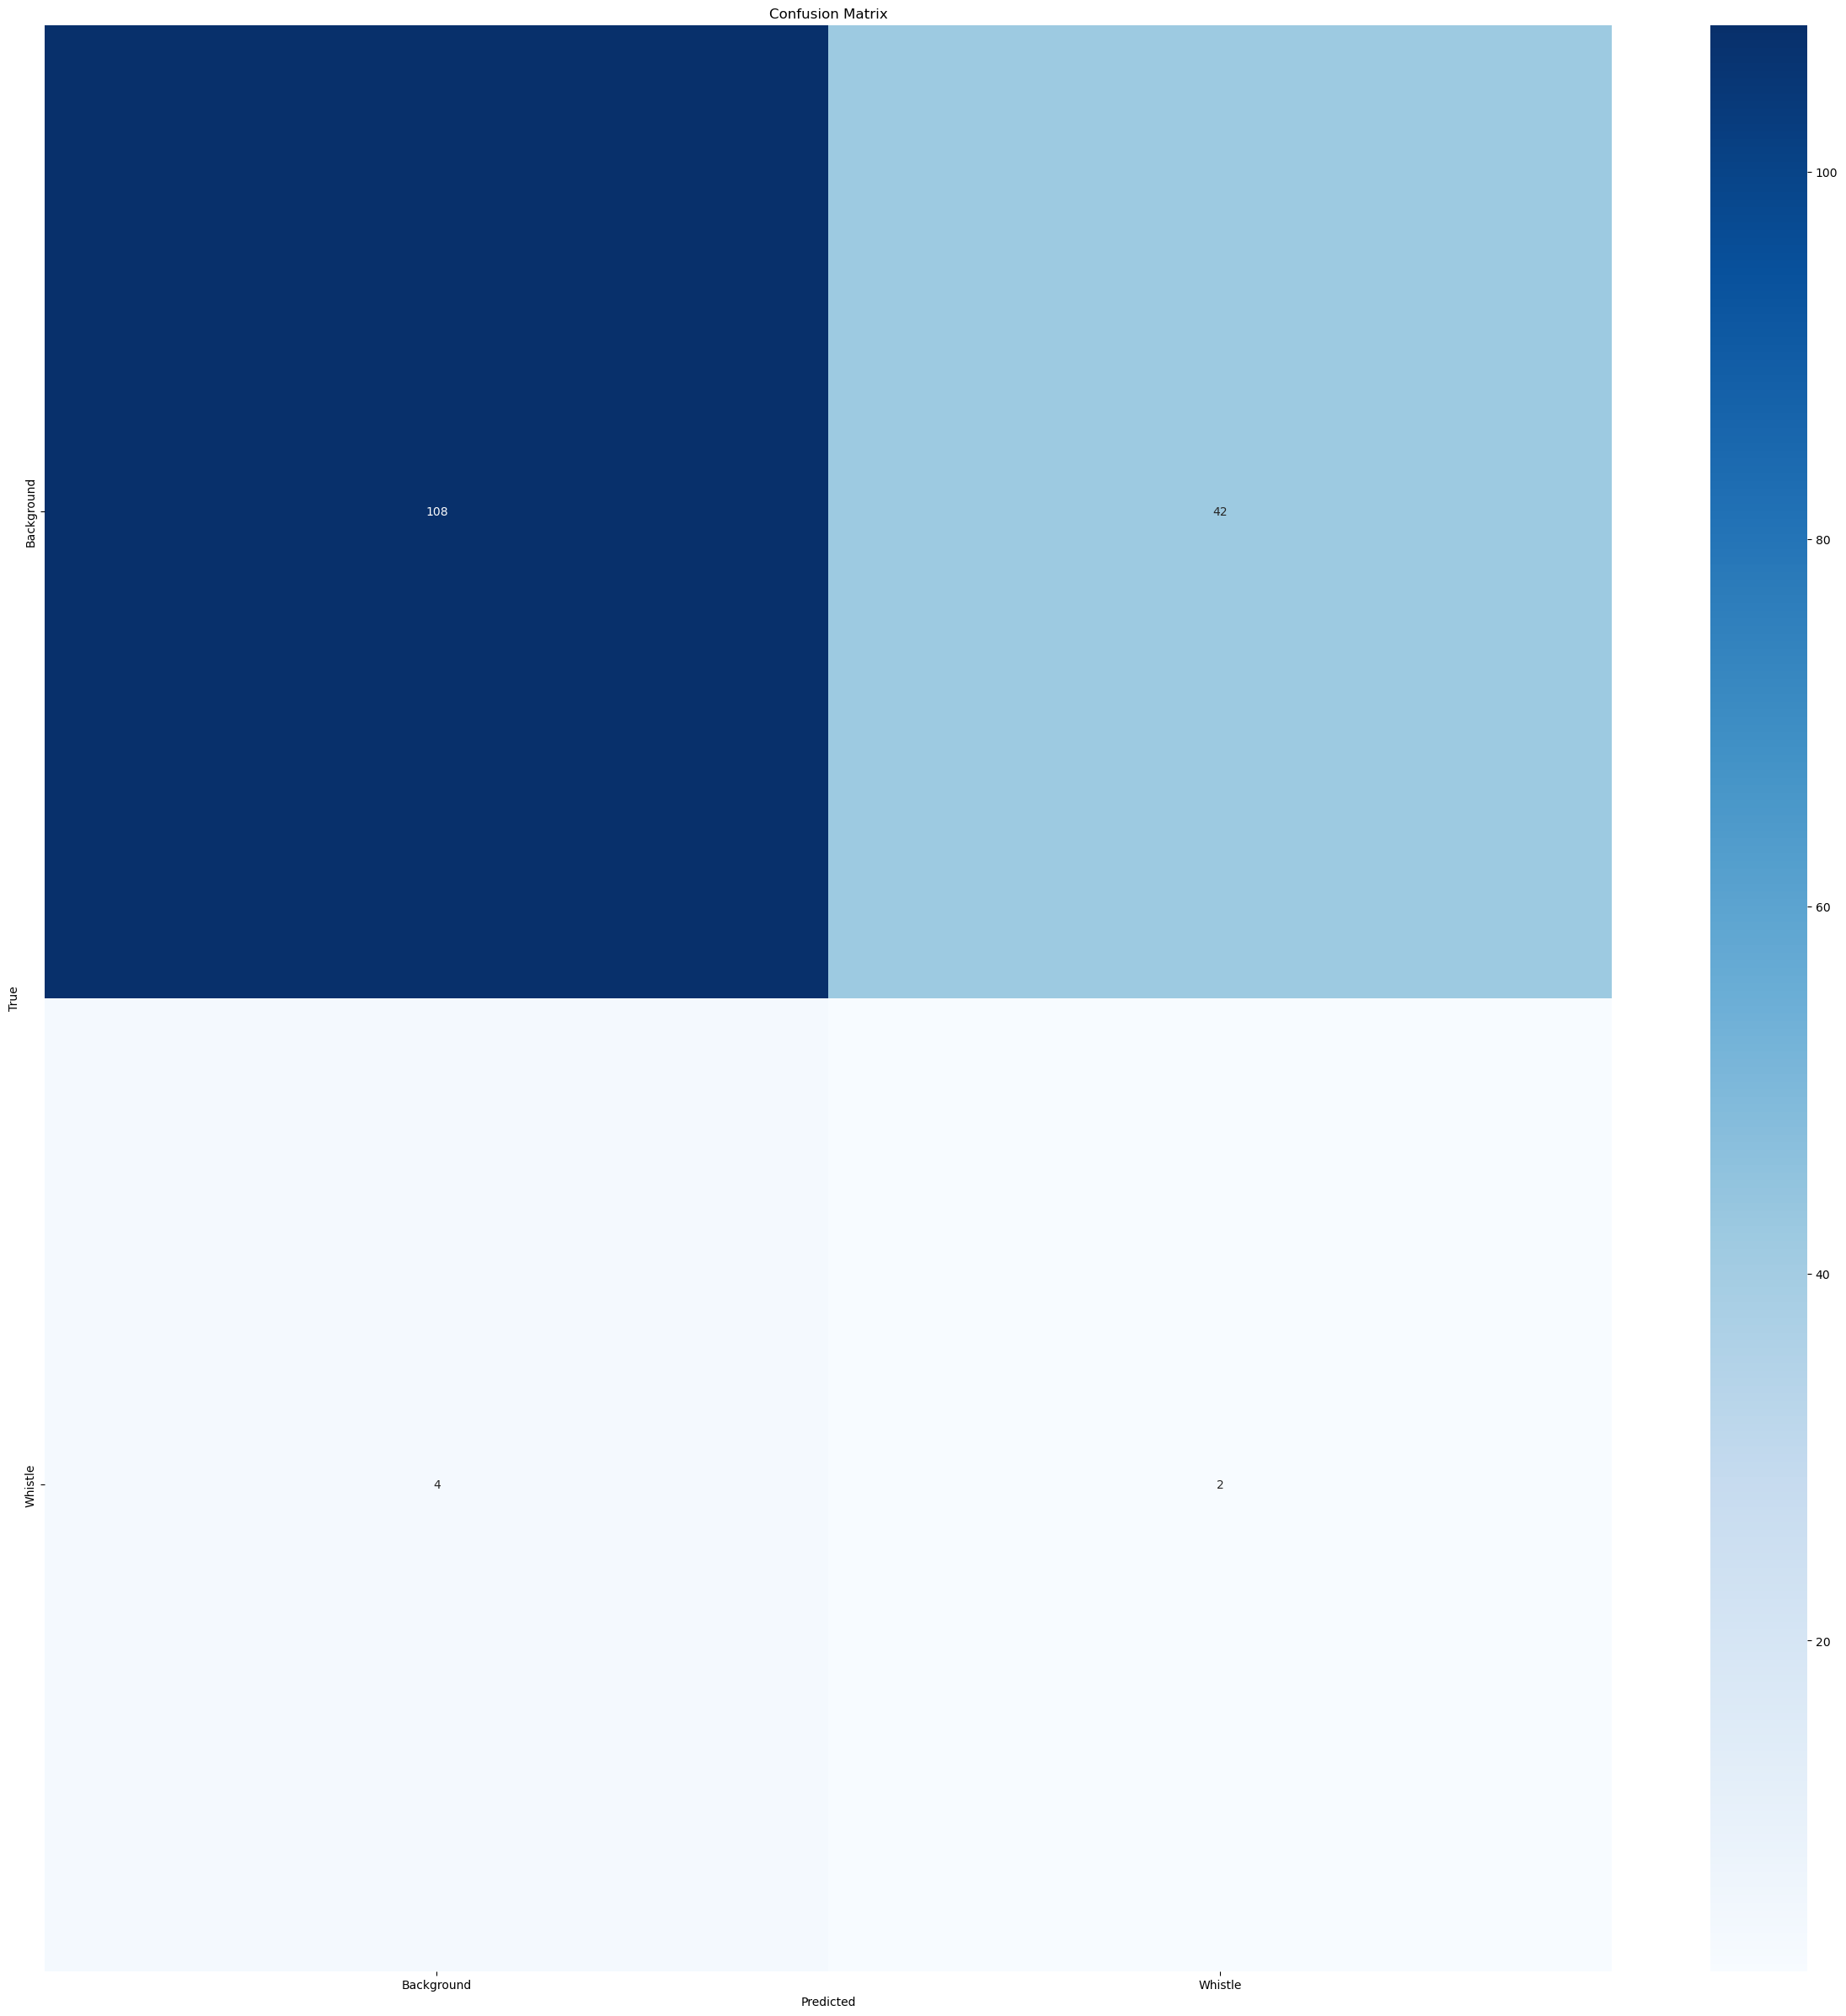

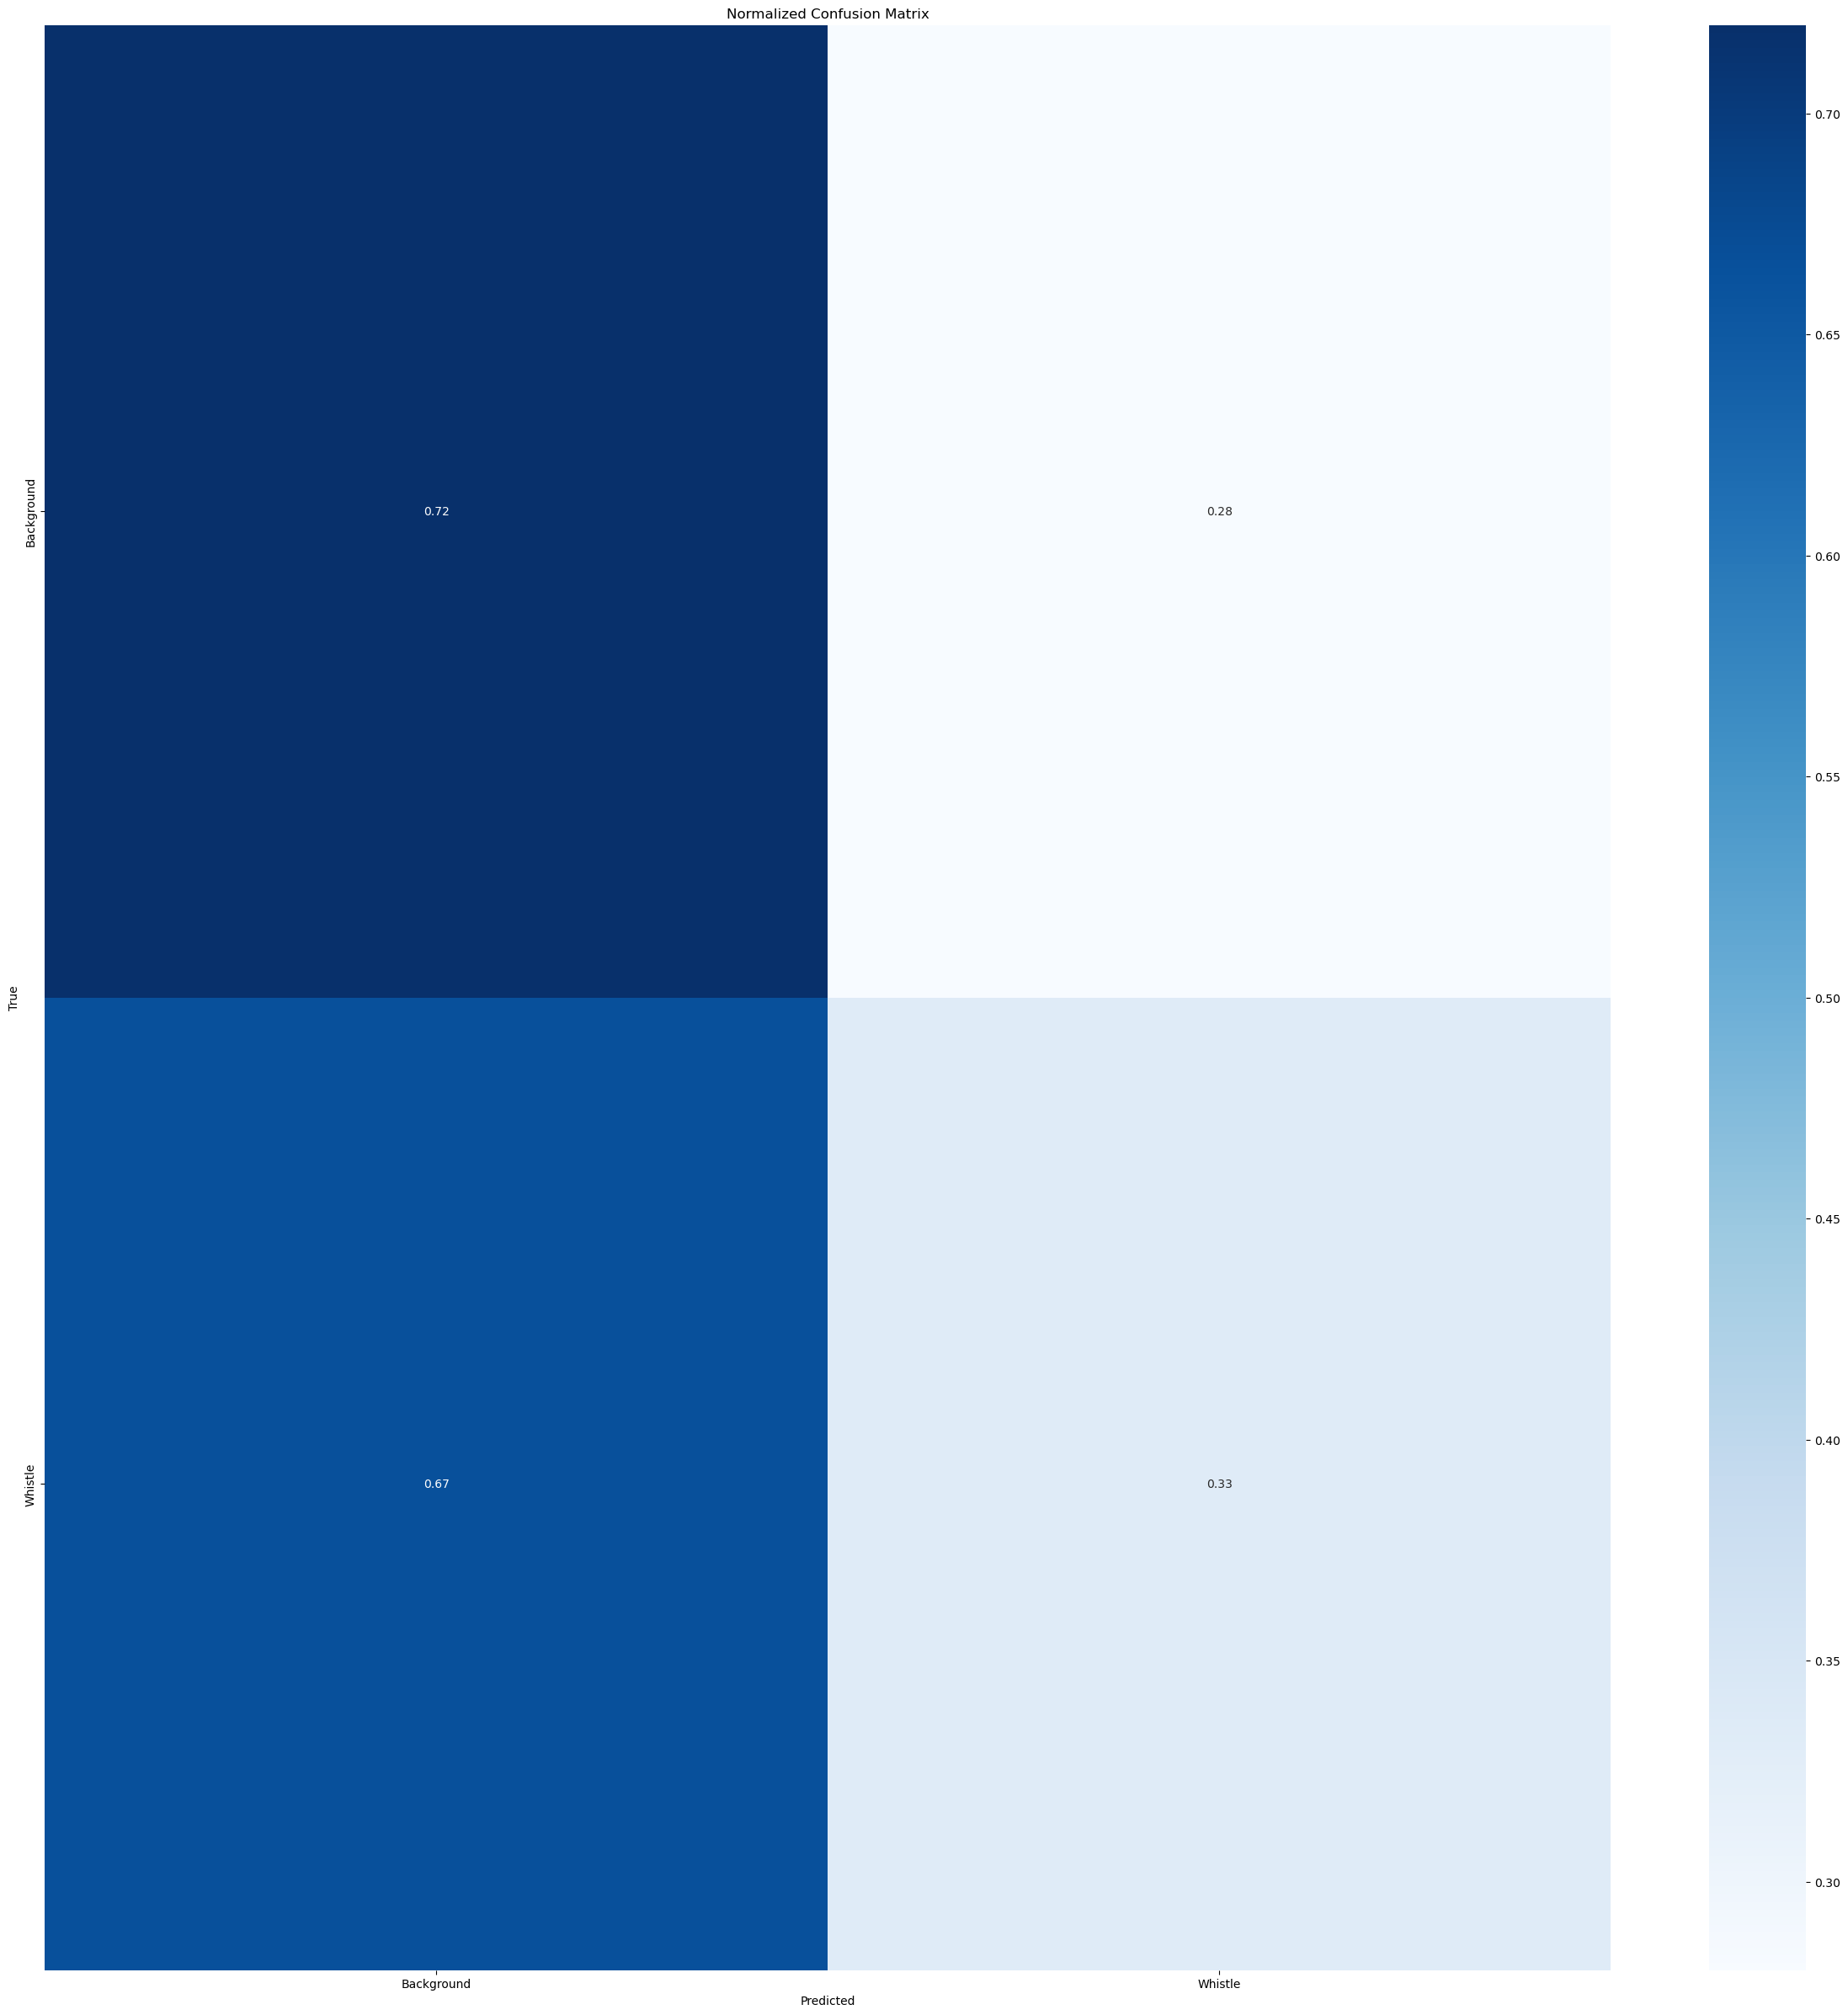

In [63]:
# test random forest on wopam
preds = best_clf.predict(wopam_emb)
# from each prediction, take the class with the highest probability
pred_classes = [birdnet.classes[i] for i in preds]  # preds is one-dimensional

# Convert one-hot encoded wopam_labels to a list of class labels
true_classes = wopam_labels.idxmax(axis=1)  # Get class name with highest value (True)
# Generate classification report
report = classification_report(true_classes, pred_classes, labels=birdnet.classes)
print(report)

# Plot confusion matrix
cm = confusion_matrix(true_classes, pred_classes, labels=birdnet.classes)
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=birdnet.classes, yticklabels=birdnet.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Normalized by rows
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(30, 30))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=birdnet.classes, yticklabels=birdnet.classes)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Use BirdNET embeddings with XGBoost

In [64]:
# take a XGBoost classifier
from sklearn.ensemble import GradientBoostingClassifier

# create several experiments for classifier and select the best one in validation
n_estimators = [10, 50, 100]
max_depth = [10, 20, 50]
best_score = 0
best_clf = None

for n in n_estimators:
    for d in max_depth:
        clf = GradientBoostingClassifier(n_estimators=n, max_depth=d, random_state=42)
        clf.fit(emb_train, train_labels.values.argmax(axis=1))
        preds = clf.predict(emb_val)
        # score = macro average f1
        score = f1_score(val_labels.values.argmax(axis=1), preds, average='macro')
        if score > best_score:
            best_score = score
            best_clf = clf

# print the best parameters
print(best_clf)

GradientBoostingClassifier(max_depth=10, random_state=42)


#### Test

              precision    recall  f1-score   support

  Background       0.99      0.98      0.98       725
     Whistle       0.98      0.99      0.99       925

    accuracy                           0.99      1650
   macro avg       0.99      0.98      0.99      1650
weighted avg       0.99      0.99      0.99      1650



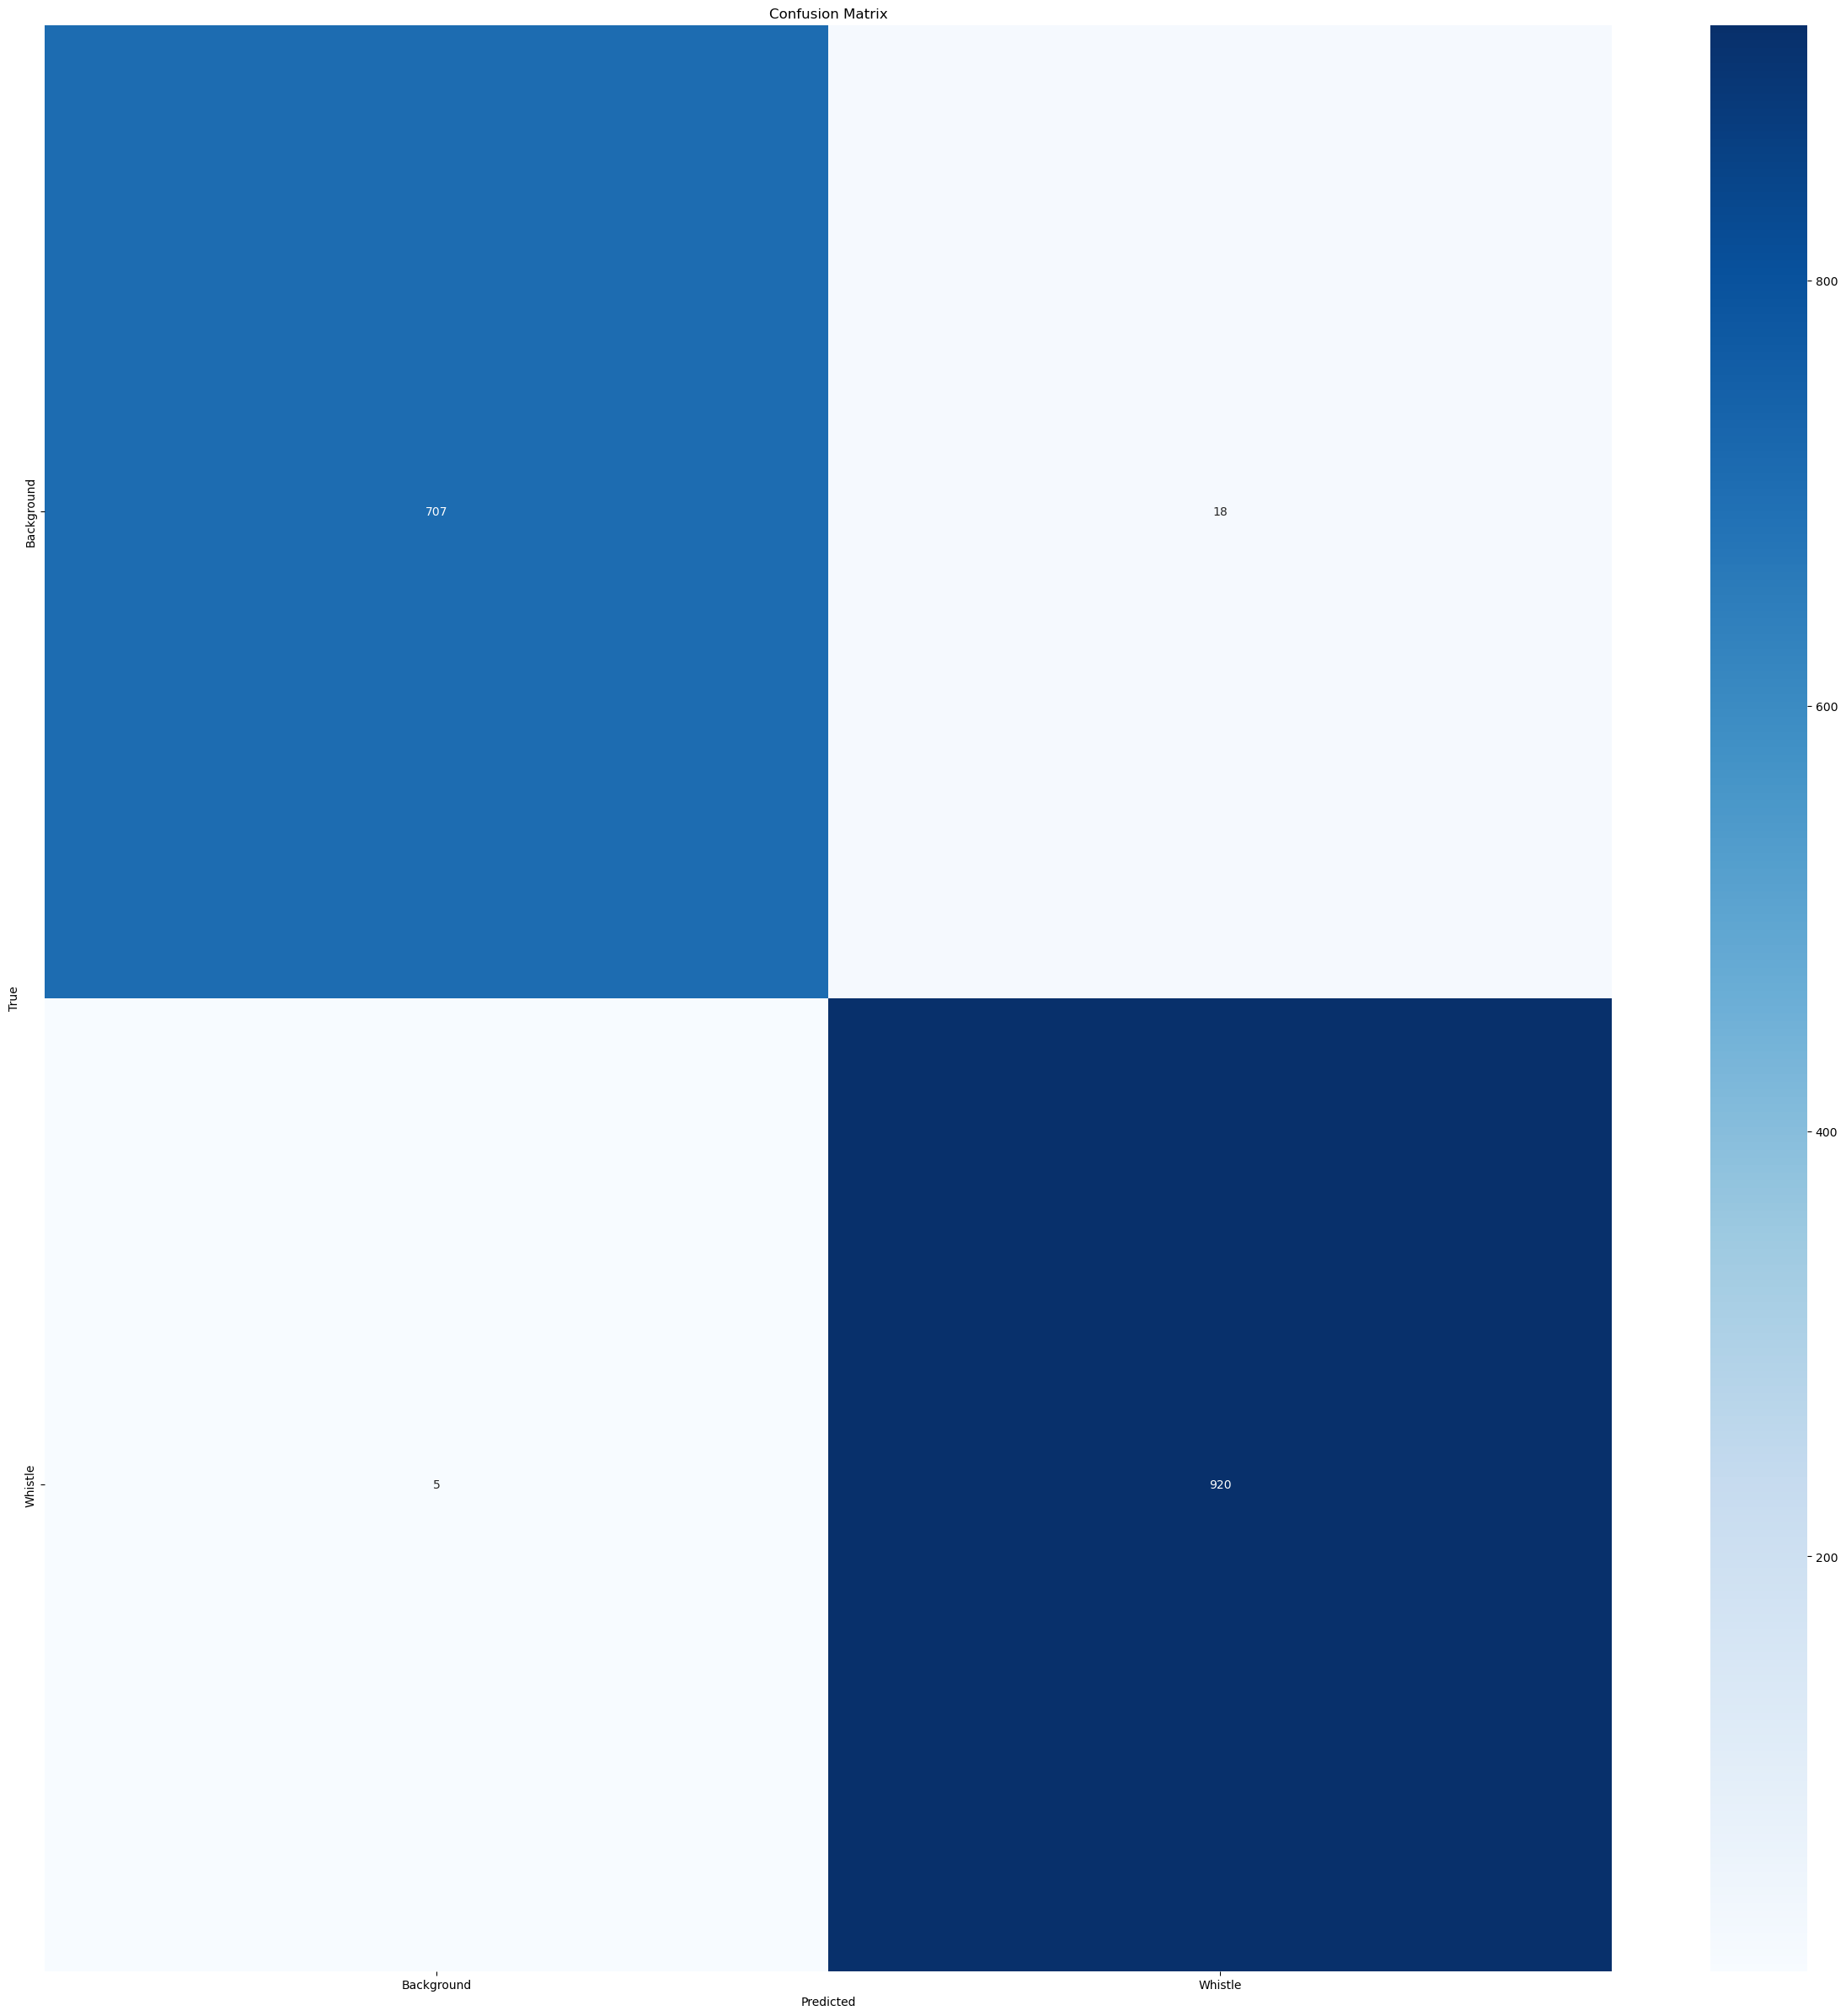

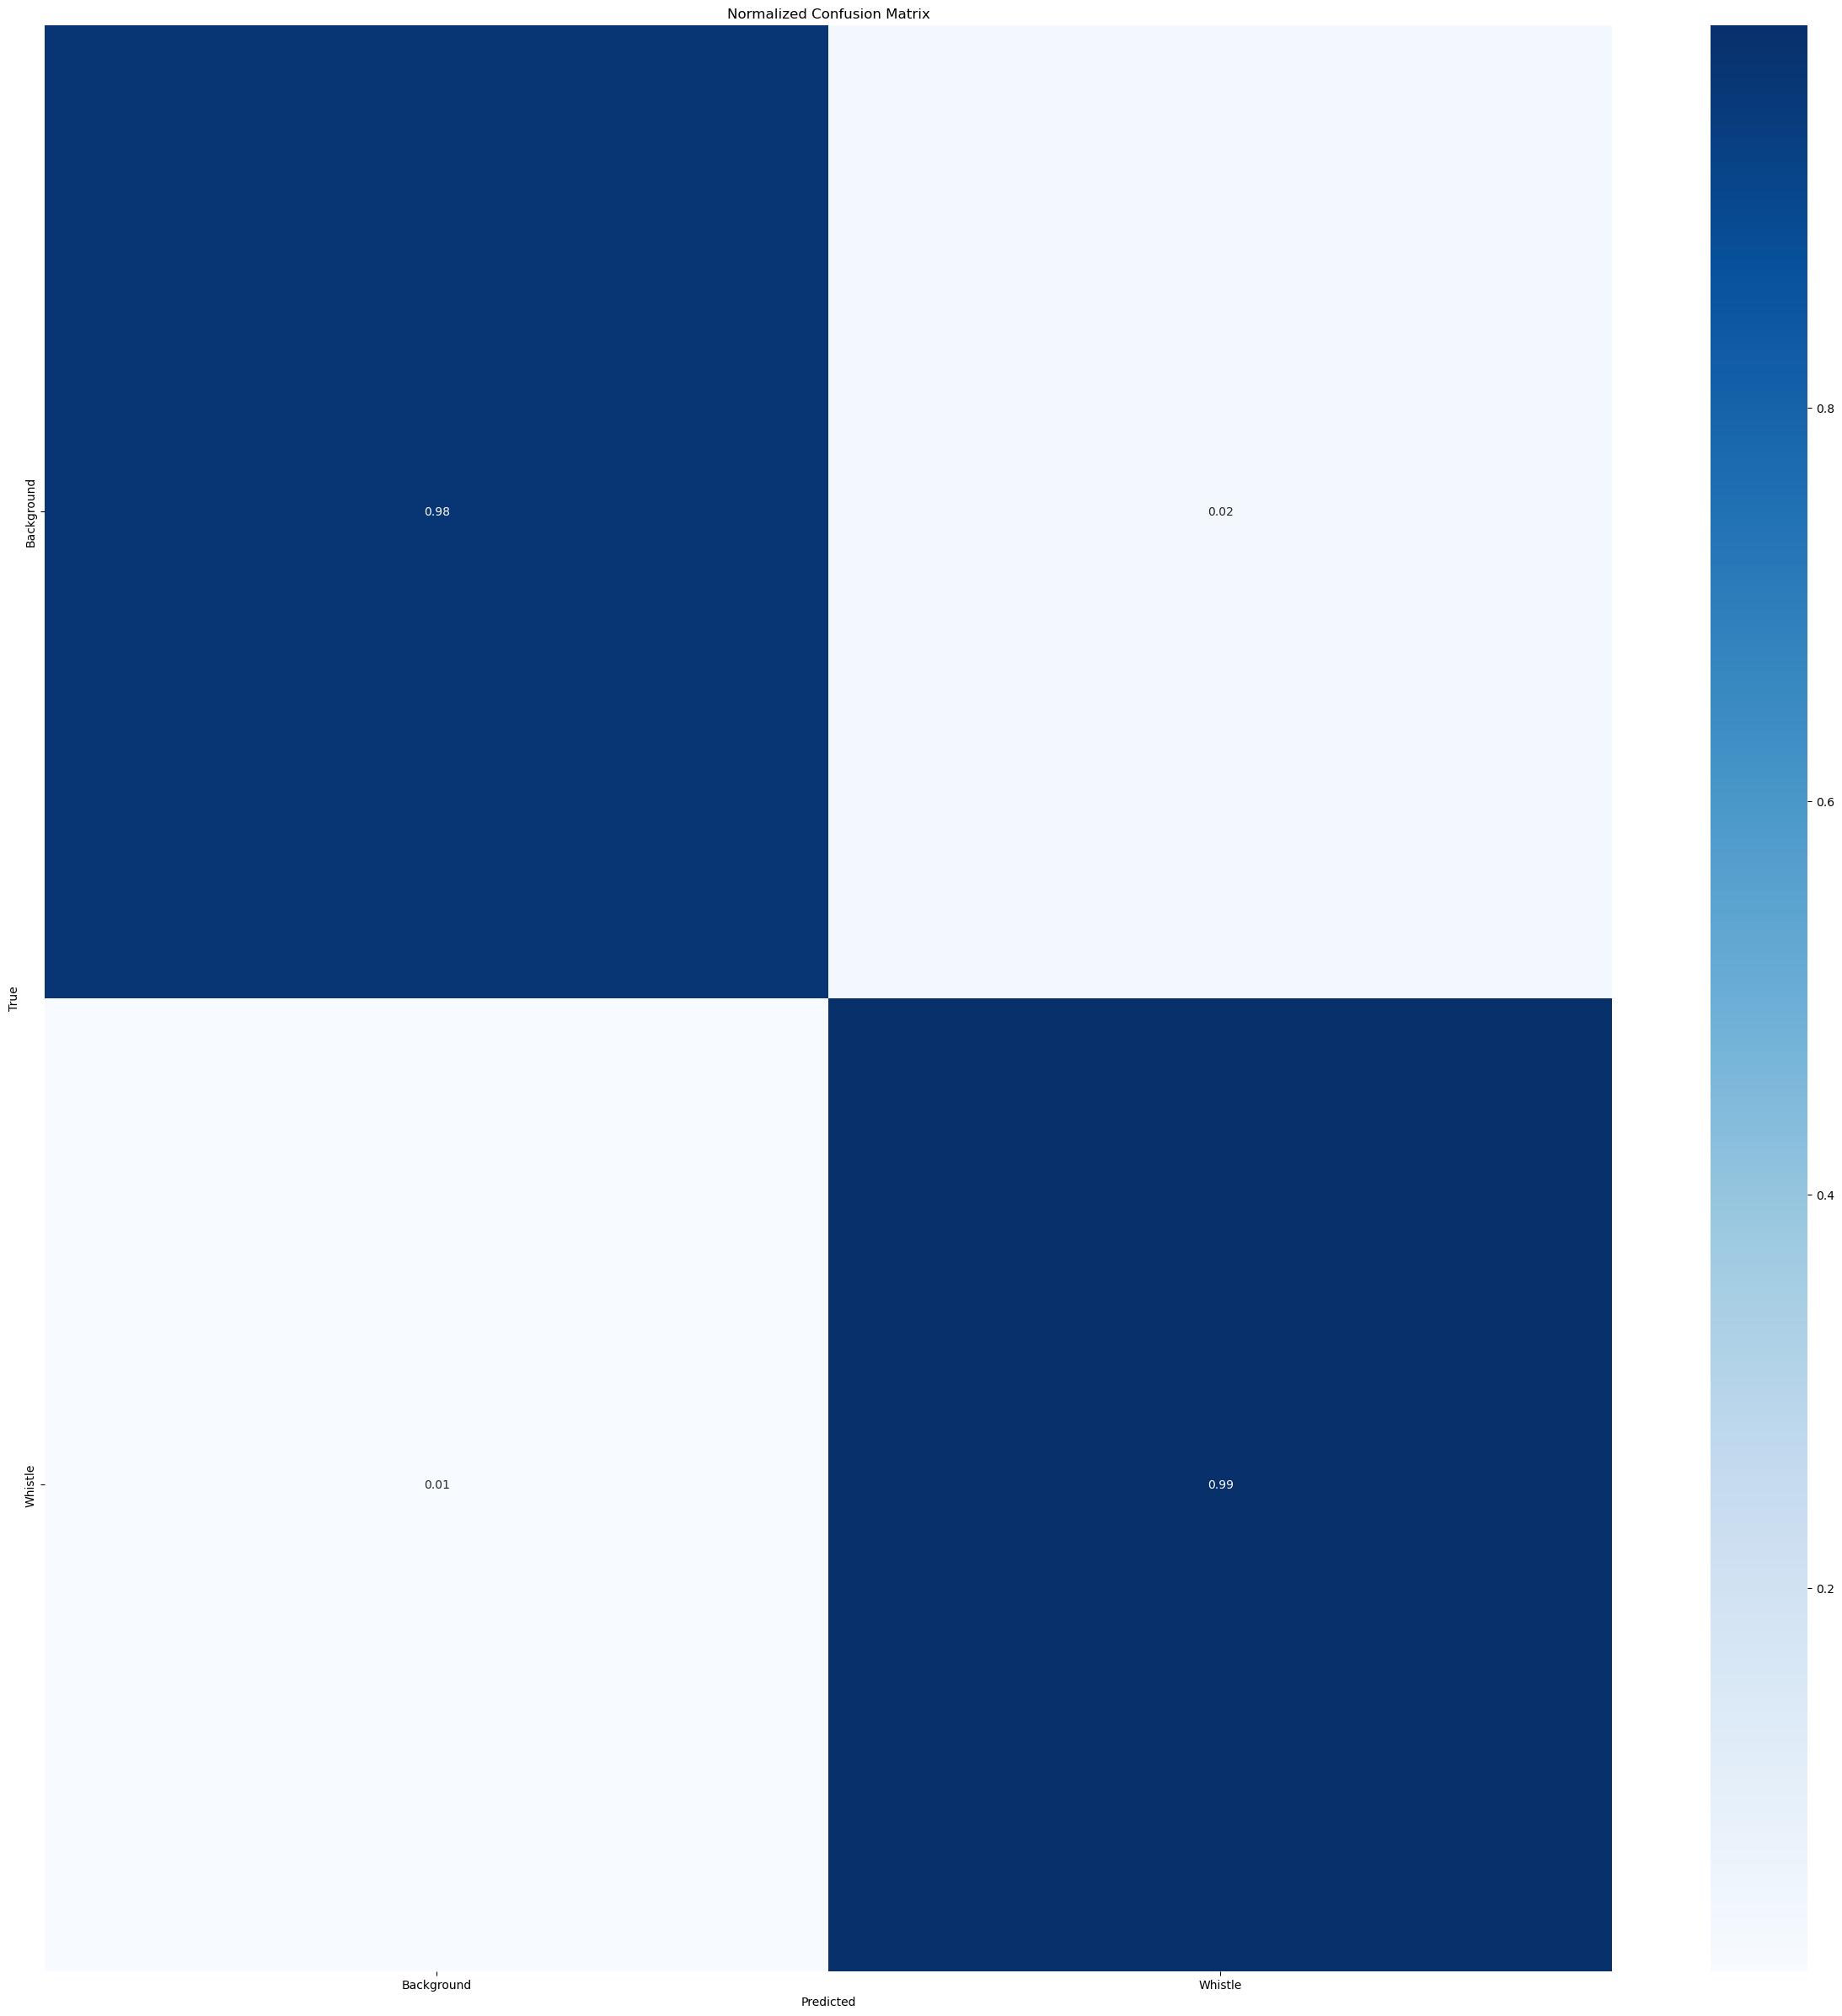

Accuracy: 0.9861
Macro F1-score: 0.9858
Weighted F1-score: 0.9860
Macro ROC-AUC Score: 0.9978


In [66]:
# make predictions on the validation set
preds = best_clf.predict(emb_test)

# from each prediction, take the class with the highest probability
# pred_classes = [birdnet.classes[i] for i in preds.argmax(axis=1)]
pred_classes = [birdnet.classes[i] for i in preds]  # preds is one-dimensional

# Convert one-hot encoded test_labels to a list of class labels
true_classes = test_labels.idxmax(axis=1)  # Get class name with highest value (True)
# Generate classification report
report = classification_report(true_classes, pred_classes)
print(report)

# Plot confusion matrix
cm = confusion_matrix(true_classes, pred_classes, labels=test_labels.columns)
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_labels.columns, yticklabels=test_labels.columns)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Normalized by rows
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(30, 30))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=test_labels.columns, yticklabels=test_labels.columns)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

accuracy = accuracy_score(true_classes, pred_classes)
print(f"Accuracy: {accuracy:.4f}")

macro_f1 = f1_score(true_classes, pred_classes, average="macro")
weighted_f1 = f1_score(true_classes, pred_classes, average="weighted")

print(f"Macro F1-score: {macro_f1:.4f}")
print(f"Weighted F1-score: {weighted_f1:.4f}")

# Assuming 'preds' contains class labels from the classifier
auc_score = roc_auc_score(test_labels.values, best_clf.predict_proba(emb_test), average="macro", multi_class="ovr")
print(f"Macro ROC-AUC Score: {auc_score:.4f}")


#### WOPAM

              precision    recall  f1-score   support

  Background       0.95      0.51      0.67       150
     Whistle       0.03      0.33      0.05         6

    accuracy                           0.51       156
   macro avg       0.49      0.42      0.36       156
weighted avg       0.92      0.51      0.64       156



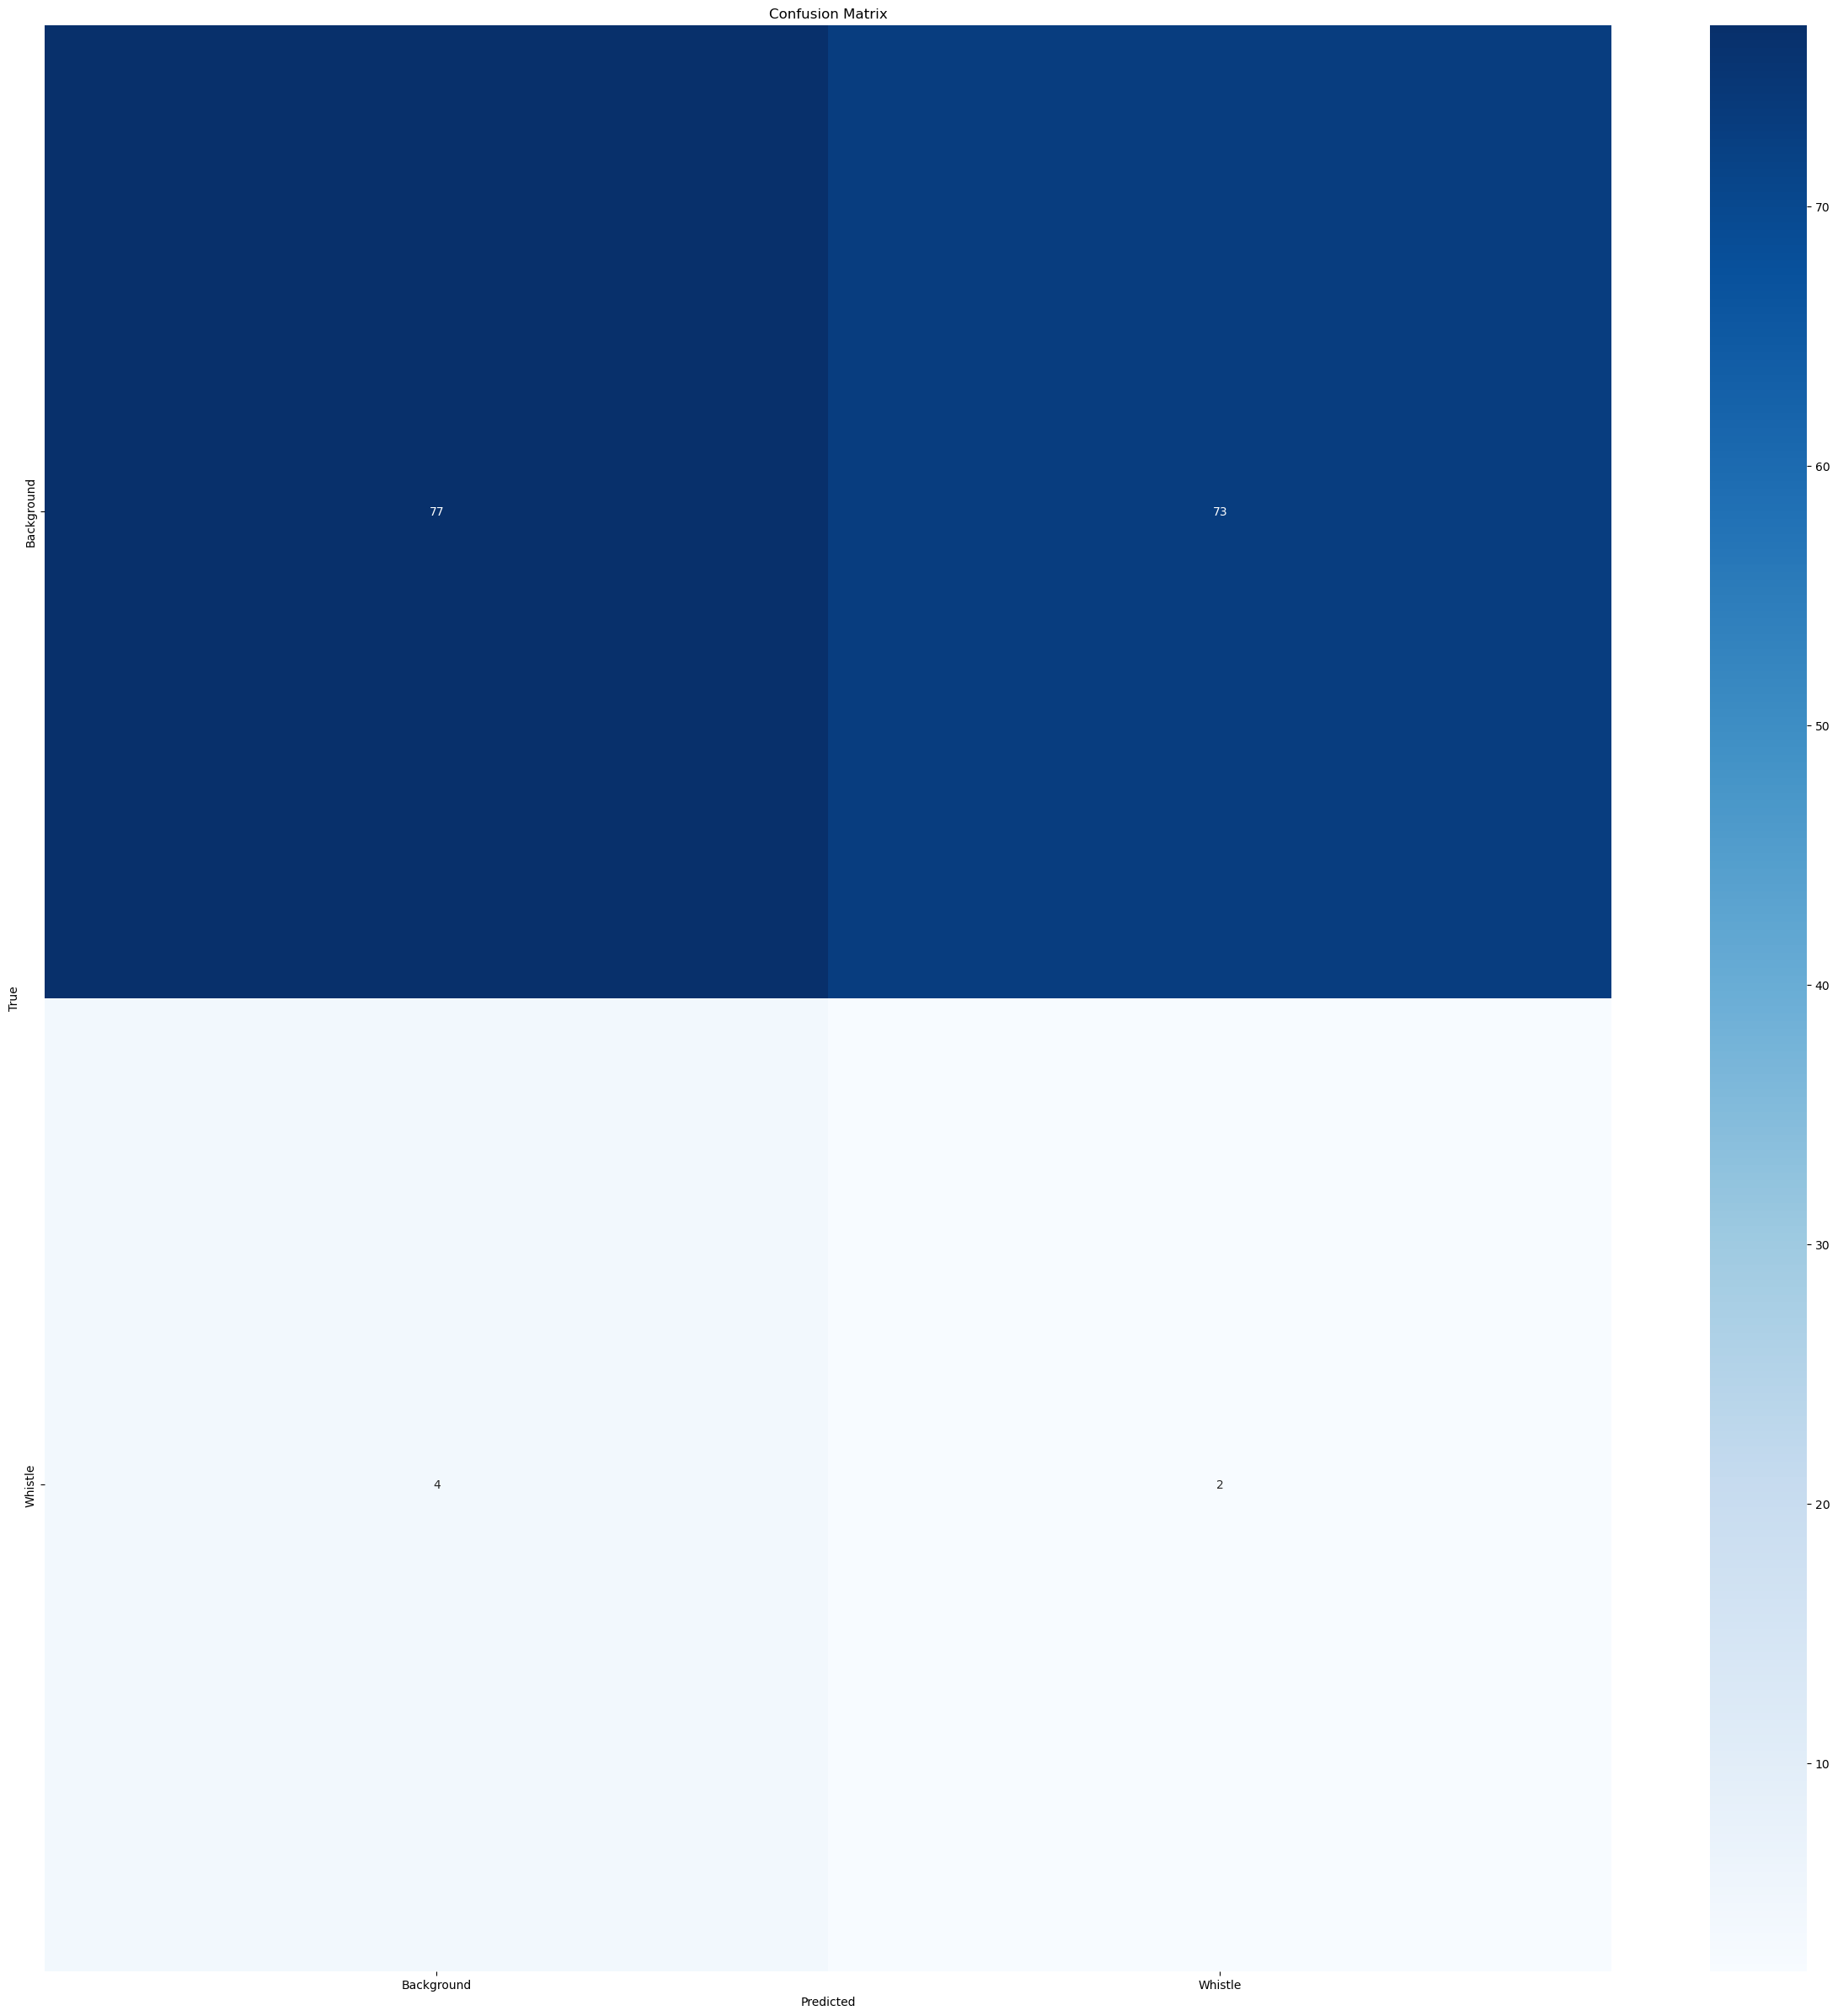

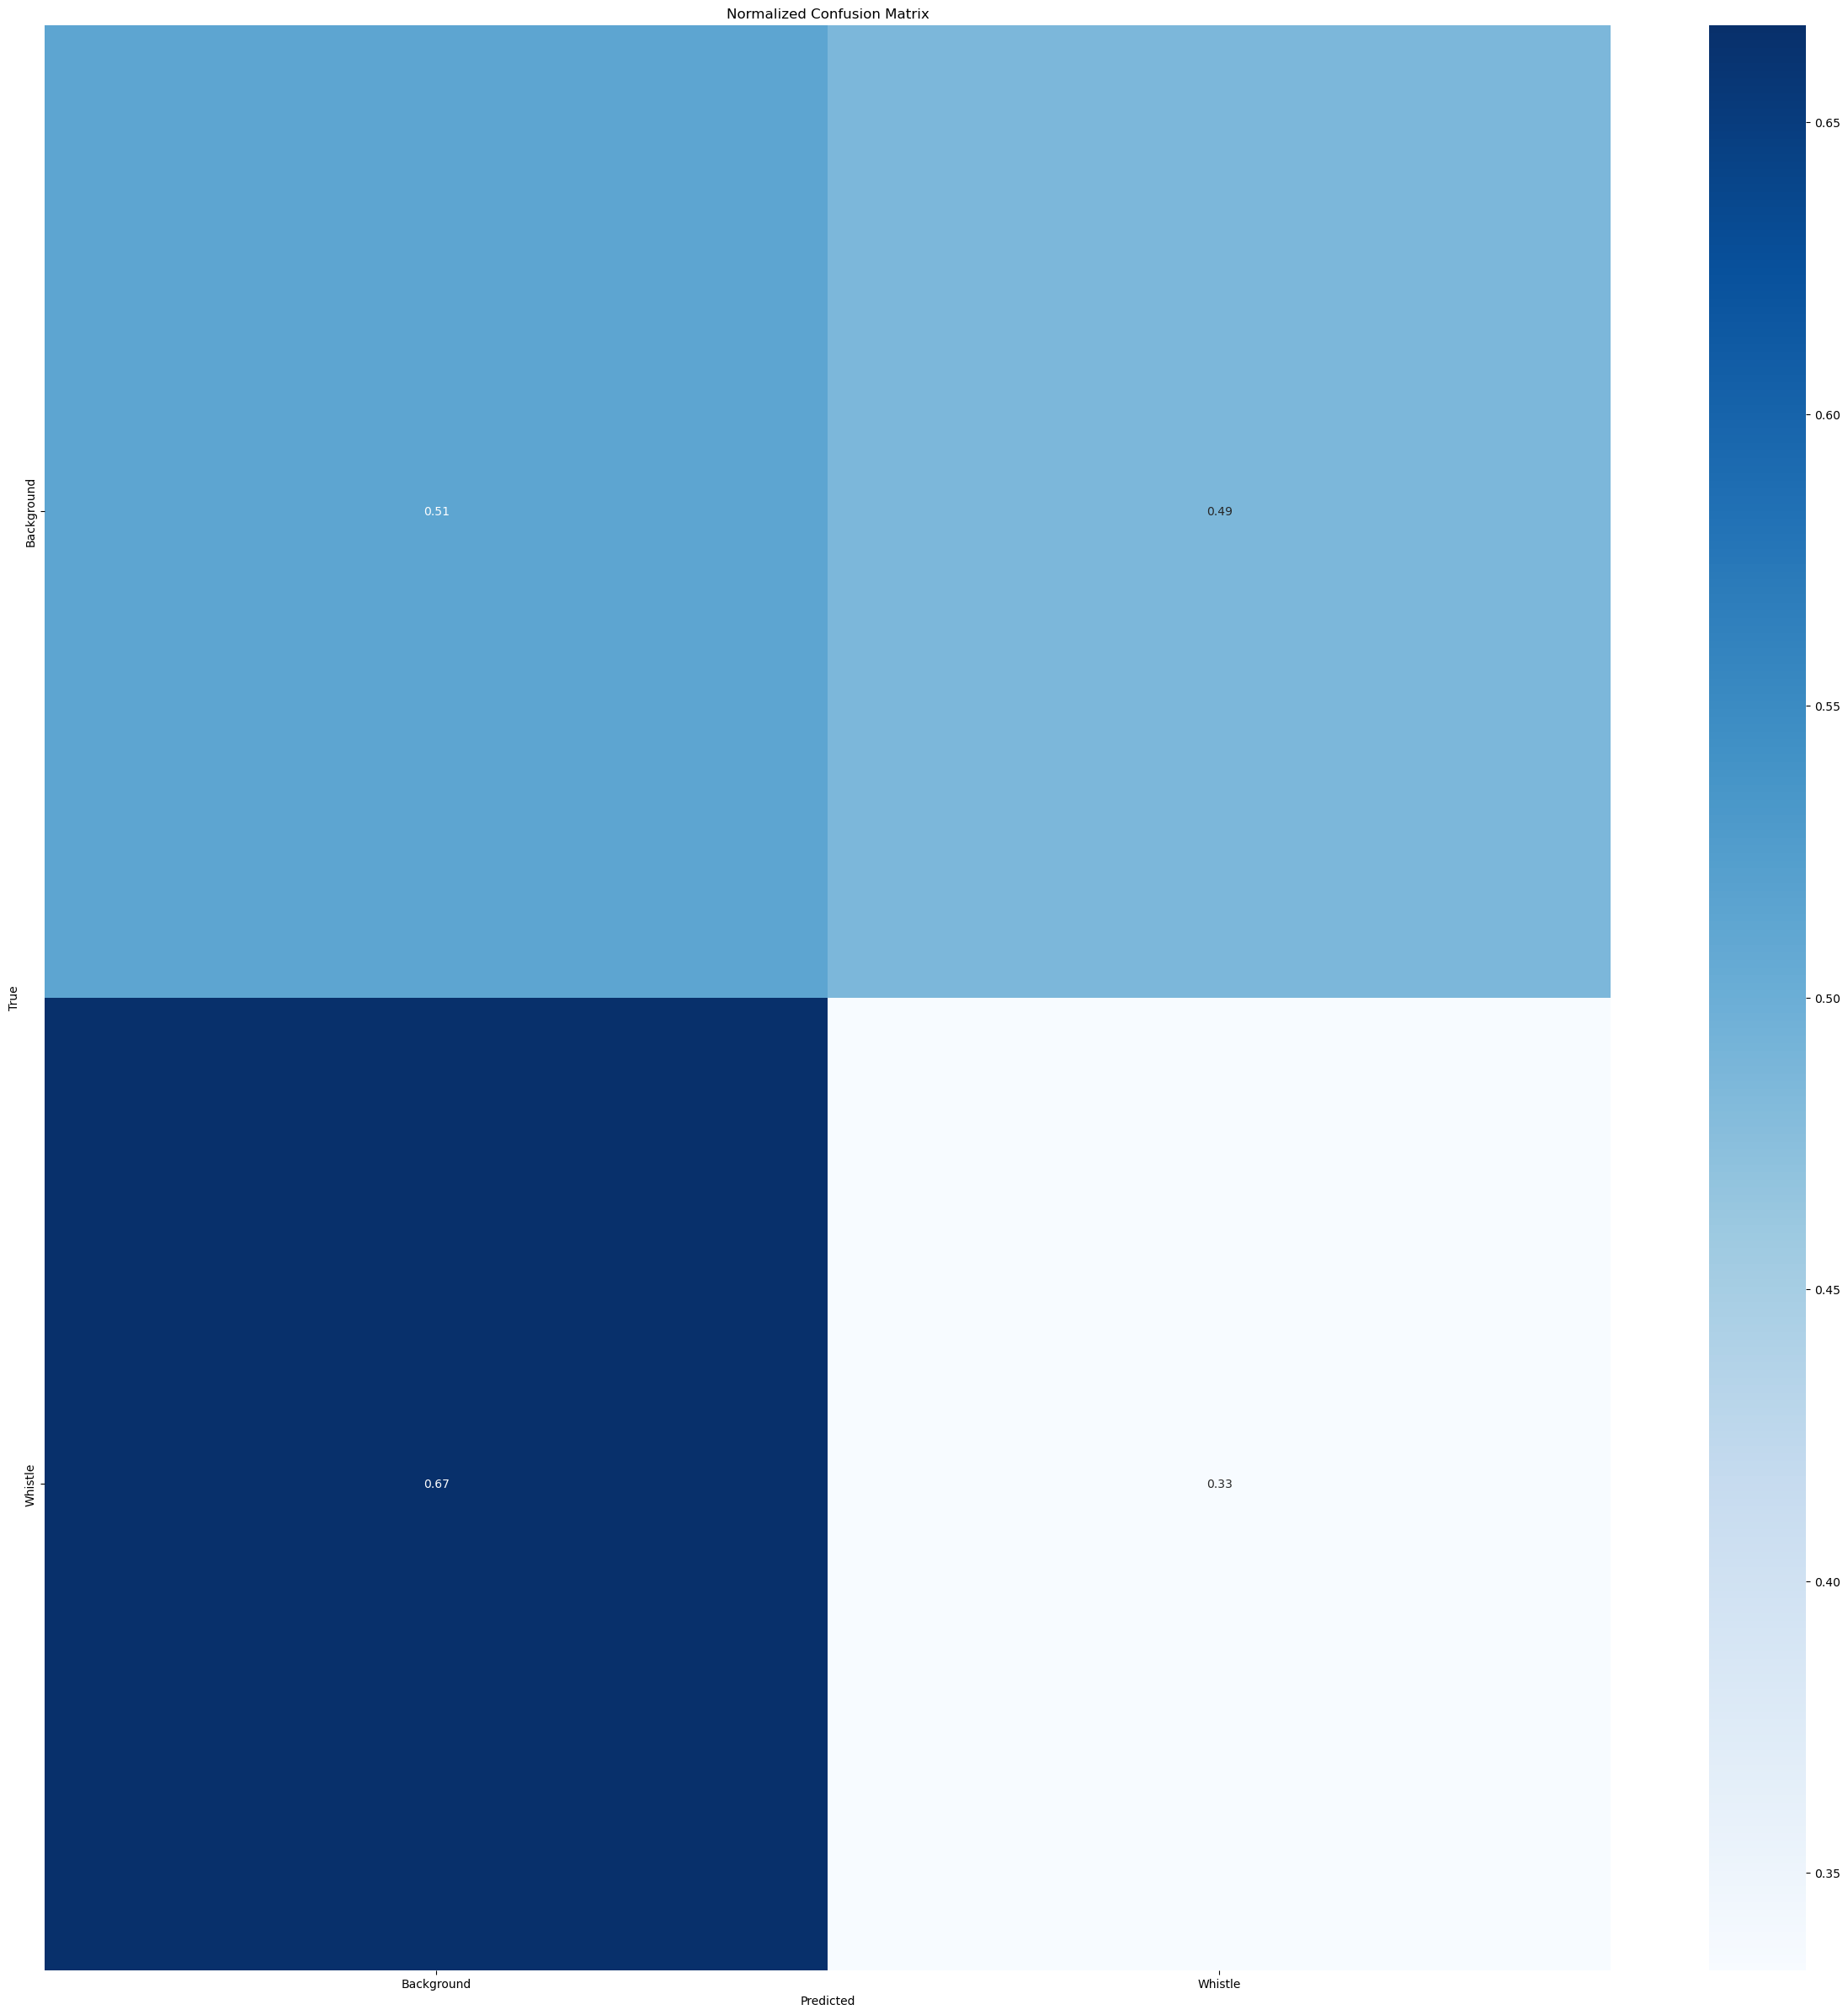

In [68]:
# test random forest on wopam
preds = best_clf.predict(wopam_emb)
# from each prediction, take the class with the highest probability
pred_classes = [birdnet.classes[i] for i in preds]  # preds is one-dimensional

# Convert one-hot encoded wopam_labels to a list of class labels
true_classes = wopam_labels.idxmax(axis=1)  # Get class name with highest value (True)
# Generate classification report
report = classification_report(true_classes, pred_classes, labels=birdnet.classes)
print(report)

# Plot confusion matrix
cm = confusion_matrix(true_classes, pred_classes, labels=birdnet.classes)
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=birdnet.classes, yticklabels=birdnet.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Normalized by rows
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(30, 30))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=birdnet.classes, yticklabels=birdnet.classes)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()